# <span id="home"> Table Of Content </span> 
- [Fashion👔👗👖👕 dataset](#1)
  - [Importing Libraries](#1.1)
  - [Reading datasets](#1.2)
- [Exploring the Images](#2)
- [HoG Features Extraction](#3)
- [SIFT Feature Extraction](#4)
  - [SIFT is not suitable for our problem](#4.1)
- [PCA](#5)
- [Scaling the Pixel values](#6)
- [Models](#7)
  - [Logistic Regression for Pixel Value dataset 🟢](#7.1)
  - [Logistic Regression for Hog dataset 🔵](#7.2)
  - [Logistic Regression for PCA dataset 🔴](#7.3)
  - [SO how about a combo dataset 🟣](#7.4)
- [K-means Clustring](#8)
- [K-means Clustring Visualisation with the help of PCA 3 components](#8.1)
- [Models Saving for deployment](#9)
- [Models Evaluation](#10)
  - [Logistic Regression Pixel Value](#10.1)
  - [Logistic Regression HoG Features](#10.2)
  - [Logistic Regression PCA 40 Features](#10.3)
  - [Logistic Regression Mix of PCA & HOG](#10.4)



<h1 id="1" style="color:salmon">Fashion👔👗👖👕 dataset</h1>

<div style="border-radius:10px;border:salmon solid;padding: 15px;background-color:#ffffff00;font-size:100%;text-align:left">

Fashion-MNIST is a dataset of [Zalando's](https://jobs.zalando.com/en/tech/?gh_src=281f2ef41us) article images—consisting of a <strong><mark style ="background-color:salmon;color:white;border-radius:4px;opacity:1.0">training set of 60,000 examples and a test set of 10,000 examples</mark></strong>. Each example is a <strong>28x28 grayscale image</strong>, associated with a label from 10 classes. We intend Fashion-MNIST to serve as a direct drop-in replacement for the original MNIST dataset for benchmarking machine learning algorithms. It shares the same image size and structure of training and testing splits.
</div>

<h2 id="11" style="color:skyblue">Importing Libraries</h2>

In [15]:
# Basic libraries
import numpy as np
import pandas as pd
import numpy as np
# visualisation
import matplotlib.pyplot as plt 
import plotly.graph_objects as go
import seaborn as sns
# for ROC curves
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
# Hog features
from skimage.feature import hog
# openCV used to try SIFT descriptors
import cv2
# PCA as way to reduce the features dim
from sklearn.decomposition import PCA
# preprocessing used in PCA
from sklearn.preprocessing import StandardScaler
# cross validation and Grid Search
from sklearn.model_selection import cross_val_score, GridSearchCV
# metrics
from sklearn.metrics import classification_report,accuracy_score, confusion_matrix

# Models
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, VotingClassifier, GradientBoostingClassifier

# Deployment and model saving
import joblib


import warnings
# To ignore all warnings
warnings.filterwarnings("ignore")

<h2 id="12" style="color:skyblue">Reading datasets</h2>

In [2]:
train = pd.read_csv('fashion-mnist_train.csv')
test = pd.read_csv('fashion-mnist_test.csv')

display(f"Train shape {train.shape}", f"Test shape {test.shape}")

'Train shape (60000, 785)'

'Test shape (10000, 785)'

In [3]:
# the dataset is represented in pixel value
# each image is 28×28 pixel => 784 and a label
train.head()

label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      2       0       0       0       0       0       0       0       0   
1      9       0       0       0       0       0       0       0       0   
2      6       0       0       0       0       0       0       0       5   
3      0       0       0       0       1       2       0       0       0   
4      3       0       0       0       0       0       0       0       0   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0       0  ...         0         0         0         0         0         0   
1       0  ...         0         0         0         0         0         0   
2       0  ...         0         0         0        30        43         0   
3       0  ...         3         0         0         0         0         1   
4       0  ...         0         0         0         0         0         0   

   pixel781  pixel782  pixel783  pixel784  
0         0         0         0         0  
1         0         0         0         0  
2         0         0         0         0  
3         0         0         0         0  
4         0         0         0         0  

[5 rows x 785 columns]

In [4]:
# we would need to scale the pixels 
# we can see for examples some pixels have max of 255 and other 0 "gray scale images"
train.describe()

label        pixel1        pixel2        pixel3        pixel4  \
count  60000.000000  60000.000000  60000.000000  60000.000000  60000.000000   
mean       4.500000      0.000900      0.006150      0.035333      0.101933   
std        2.872305      0.094689      0.271011      1.222324      2.452871   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        2.000000      0.000000      0.000000      0.000000      0.000000   
50%        4.500000      0.000000      0.000000      0.000000      0.000000   
75%        7.000000      0.000000      0.000000      0.000000      0.000000   
max        9.000000     16.000000     36.000000    226.000000    164.000000   

             pixel5        pixel6        pixel7        pixel8        pixel9  \
count  60000.000000  60000.000000  60000.000000  60000.000000  60000.000000   
mean       0.247967      0.411467      0.805767      2.198283      5.682000   
std        4.306912      5.836188      8.215169     14.093378     23.819481   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max      227.000000    230.000000    224.000000    255.000000    254.000000   

       ...      pixel775      pixel776      pixel777      pixel778  \
count  ...  60000.000000  60000.000000  60000.000000  60000.000000   
mean   ...     34.625400     23.300683     16.588267     17.869433   
std    ...     57.545242     48.854427     41.979611     43.966032   
min    ...      0.000000      0.000000      0.000000      0.000000   
25%    ...      0.000000      0.000000      0.000000      0.000000   
50%    ...      0.000000      0.000000      0.000000      0.000000   
75%    ...     58.000000      9.000000      0.000000      0.000000   
max    ...    255.000000    255.000000    255.000000    255.000000   

           pixel779      pixel780      pixel781      pixel782      pixel783  \
count  60000.000000  60000.000000  60000.000000  60000.000000  60000.000000   
mean      22.814817     17.911483      8.520633      2.753300      0.855517   
std       51.830477     45.149388     29.614859     17.397652      9.356960   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        0.000000      0.000000      0.000000      0.000000      0.000000   
75%        0.000000      0.000000      0.000000      0.000000      0.000000   
max      255.000000    255.000000    255.000000    255.000000    255.000000   

          pixel784  
count  60000.00000  
mean       0.07025  
std        2.12587  
min        0.00000  
25%        0.00000  
50%        0.00000  
75%        0.00000  
max      170.00000  

[8 rows x 785 columns]

<h1 id="2" style="color:salmon">Exploring the Images</h1>

In [3]:
def showOneImage(row, df=train, colors = "gray"):
    '''
    This function show one image at any row of the dataframe
    default dataframe is train
    default color is gray
    '''
    # talking the row and from column 1 "the column after the label"
    plt.imshow(df.iloc[row, 1:].values.reshape(28,28), cmap=colors)


def showLabel(label, df=train, n=50):
    '''
    Show by default 50 sample of images for a specific label
    default dataframe train 
    '''
    # select all rows where label == to the label I search for
    labelselect = df.loc[df['label'] == label, "label":]

    # figure to plot the images
    plt.figure(figsize=(10,5), dpi=150)

    # loop to plot in the subplot
    # loop in range of the min between the n the user selected and the len of all rows matching that label
    # you can't plot more than what already exist in the dataframe
    for i in range(min(n, len(labelselect))):
        # subplot(nrows, ncols, index_of_current_plot)
        # n must be divisable by 10 it control the number of rows each row has 10 cols (images)
        plt.subplot(n // 10, 10, i + 1) 
        image_data = labelselect.iloc[i, 1:].values.reshape(28, 28) 
        plt.imshow(image_data, cmap='gray')
        plt.xticks([])
        plt.yticks([])

    plt.show()


'label 0'

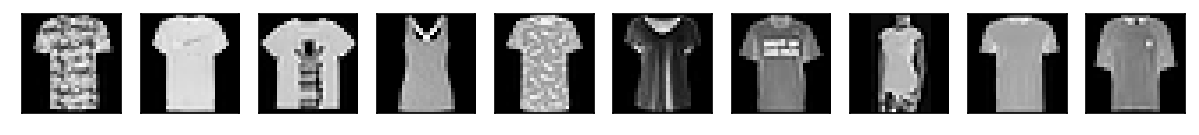

'label 1'

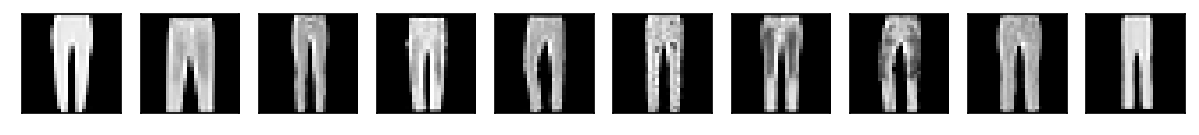

'label 2'

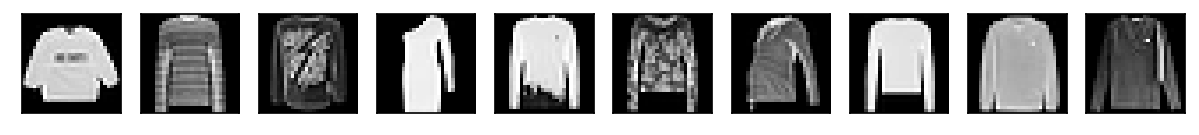

'label 3'

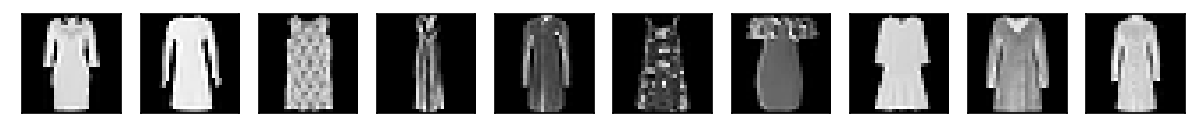

'label 4'

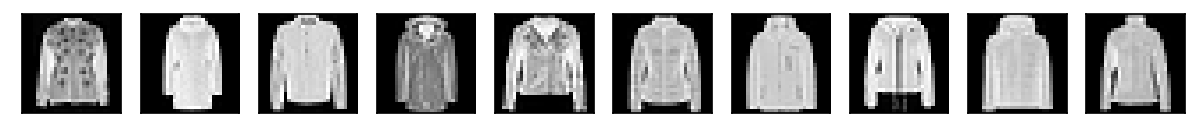

'label 5'

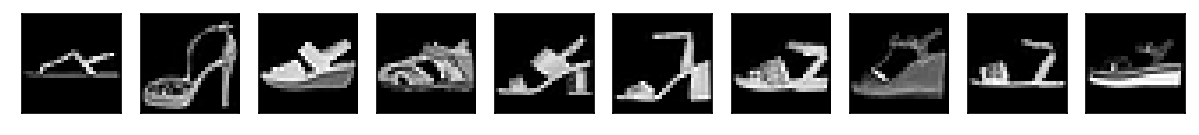

'label 6'

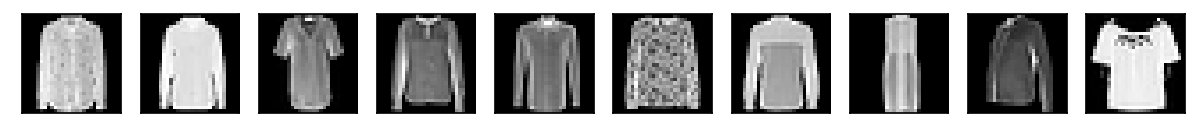

'label 7'

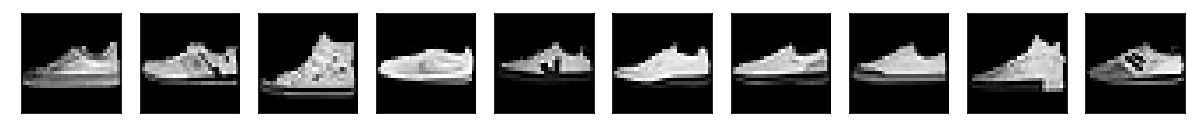

'label 8'

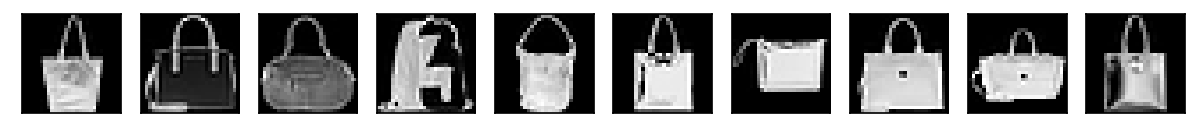

'label 9'

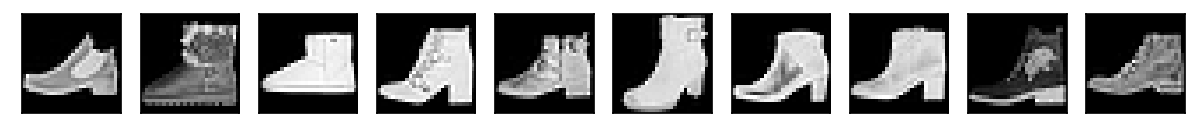

In [6]:
for label in range(10):
    display(f"label {label}")
    showLabel(label, n=10)


<h1 id="3" style="color:salmon">HoG Features Extraction</h1>

In [4]:
# Function to compute HOG features for a single image
def compute_hog_features(image):
    # Reshape the image to its original shape (28x28 for MNIST)
    image = image.reshape((28, 28))
    # Compute HOG features
    # features, hog_image = hog(image, orientations=8, pixels_per_cell=(4, 4), cells_per_block=(1, 1), visualize=True)
    features, hog_image = hog(image, orientations=8, visualize=True)
    return features, hog_image


'The shape of the HoG (72,)'

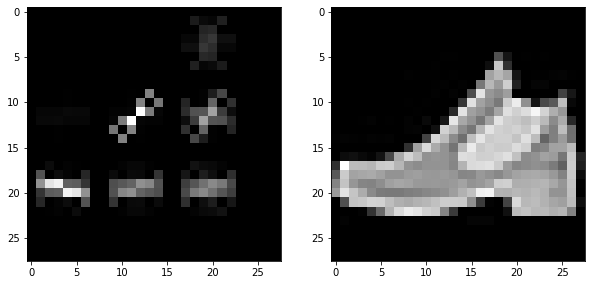

In [8]:
# which image to show 
row = 1

# figure and the row axes we need to plot the image and it's hog featured
fig, (ax0, ax1) = plt.subplots(1,2, figsize=(10,10))

features, hog_image = compute_hog_features(train.iloc[row, 1:].values)

display(f"The shape of the HoG {features.shape}")

# features, hog_image
ax0.imshow(hog_image, cmap="gray");
ax1.imshow(train.iloc[row, 1:].values.reshape(28,28), cmap="gray");

In [28]:
#  iterrows() -> each iteration returns a tuple containing the index and the row data
# compute_hog_features()[0] -> the hog features only what I need
# train.iloc[row, 1:].values similar to row[1:].values as each row in the dataset we don't want to take the label with us

train_hog = [compute_hog_features(row[1:].values)[0] for _, row in train.iterrows()]
# train_hog

In [29]:
# testing how to reshape one array of HoG features 
train_hog[0].reshape(1, -1).shape

(1, 72)

In [30]:
# reshaping the features array for all the images into one structure (60k) rows and 72 cols or features
train_hog = np.array(train_hog).reshape(len(train_hog),-1)
# checking the shape
train_hog.shape

(60000, 72)

In [31]:
# hog_df 
train_hog_df = pd.DataFrame(train_hog)
train_hog_df.head()

0         1         2         3         4         5         6   \
0  0.057845  0.194040  0.207260  0.068280  0.058807  0.000489  0.000000   
1  0.000394  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2  0.257989  0.225401  0.105295  0.028898  0.009615  0.000000  0.001612   
3  0.128701  0.175918  0.190101  0.058635  0.044771  0.016389  0.018411   
4  0.257131  0.141440  0.000000  0.000000  0.000000  0.000000  0.000000   

         7         8         9   ...        62        63        64        65  \
0  0.003777  0.011969  0.084600  ...  0.025372  0.014512  0.237629  0.067363   
1  0.000000  0.001181  0.000000  ...  0.013579  0.030951  0.041209  0.020112   
2  0.013724  0.083109  0.166780  ...  0.046172  0.059946  0.290640  0.022658   
3  0.001277  0.153229  0.044253  ...  0.148202  0.166557  0.127487  0.056144   
4  0.040207  0.135338  0.046181  ...  0.047053  0.253988  0.265136  0.000772   

         66        67        68        69        70        71  
0  0.006902  0.041049  0.087453  0.201157  0.081416  0.065727  
1  0.198062  0.270952  0.259899  0.092271  0.074821  0.047910  
2  0.068237  0.000000  0.022346  0.039562  0.020390  0.290640  
3  0.091727  0.088432  0.046796  0.080052  0.097072  0.205857  
4  0.000244  0.000546  0.002763  0.000000  0.000867  0.166677  

[5 rows x 72 columns]

In [32]:
# adding the label to the new dataframe 
train_hog_df["label"] = train["label"]
train_hog_df.sample(10)

0         1         2         3         4         5    6  \
20617  0.004040  0.000000  0.000000  0.000000  0.000000  0.000000  0.0   
40471  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0   
46684  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0   
58933  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0   
34040  0.001077  0.000000  0.000000  0.000000  0.000000  0.000000  0.0   
46000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0   
15261  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0   
56431  0.144165  0.115226  0.035766  0.000000  0.000000  0.000000  0.0   
8501   0.175448  0.146883  0.067996  0.009039  0.007751  0.007658  0.0   
28802  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.0   

              7         8         9  ...        63        64        65  \
20617  0.000000  0.330301  0.096458  ...  0.330301  0.330301  0.000000   
40471  0.000000  0.076918  0.000000  ...  0.007852  0.034940  0.018952   
46684  0.000000  0.348448  0.060800  ...  0.170906  0.267205  0.000000   
58933  0.000000  0.000000  0.000000  ...  0.018000  0.004021  0.000000   
34040  0.000000  0.265311  0.186495  ...  0.056972  0.290838  0.167905   
46000  0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
15261  0.000000  0.000000  0.000000  ...  0.019716  0.014550  0.022761   
56431  0.012357  0.294796  0.104220  ...  0.239091  0.100231  0.004888   
8501   0.047018  0.012521  0.027319  ...  0.090323  0.284707  0.020412   
28802  0.000000  0.000000  0.000000  ...  0.049397  0.000000  0.012702   

             66        67        68        69        70        71  label  
20617  0.000000  0.003013  0.000000  0.000000  0.010331  0.149371      1  
40471  0.098158  0.315602  0.250780  0.013712  0.089624  0.098796      9  
46684  0.001067  0.000000  0.000000  0.000000  0.000337  0.348448      1  
58933  0.030388  0.294026  0.294026  0.000000  0.000000  0.000000      9  
34040  0.290838  0.105984  0.091556  0.005259  0.011054  0.136747      9  
46000  0.000000  0.304510  0.304510  0.000000  0.000000  0.000000      7  
15261  0.007573  0.257879  0.257879  0.168114  0.055282  0.008263      5  
56431  0.001040  0.000000  0.009289  0.007919  0.035972  0.260135      3  
8501   0.001698  0.000000  0.013534  0.021150  0.143638  0.292707      2  
28802  0.015296  0.261877  0.263487  0.030970  0.124013  0.066302      5  

[10 rows x 73 columns]

In [33]:
# let's do the same steps fot the test dataset 
# iterrows(), each iteration returns a tuple containing the index and the row data
test_hog = [compute_hog_features(row[1:].values)[0] for _, row in test.iterrows()]

# reshaping 
# reshape(#Rows, #Cols) 
# reshape(60k, -1 mean as much as you need of colums) 
test_hog = np.array(test_hog).reshape(len(test_hog), -1)

# creating test_hog_df dataframe 
test_hog_df = pd.DataFrame(test_hog)

# adding labels 
test_hog_df["label"] = test["label"]

# displaying a sample
test_hog_df.sample(10)

0         1         2         3         4         5         6  \
6455  0.006581  0.000000  0.000000  0.000000  0.006581  0.000000  0.000000   
2260  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
9992  0.110371  0.000000  0.000942  0.000000  0.000666  0.000000  0.000000   
707   0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
8947  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
7454  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
9850  0.291244  0.037210  0.000000  0.000000  0.000000  0.000000  0.000000   
4985  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2420  0.246882  0.105711  0.176936  0.045964  0.028178  0.064888  0.012033   
5898  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   

             7         8         9  ...        63        64        65  \
6455  0.000000  0.254311  0.109148  ...  0.090649  0.226844  0.056430   
2260  0.000000  0.337248  0.060820  ...  0.337248  0.337248  0.000000   
9992  0.000000  0.298428  0.190275  ...  0.044898  0.298428  0.057953   
707   0.000000  0.000000  0.000000  ...  0.000000  0.000000  0.000000   
8947  0.000000  0.250068  0.008384  ...  0.054585  0.250068  0.157987   
7454  0.000000  0.349387  0.095934  ...  0.349387  0.349387  0.000000   
9850  0.000000  0.114587  0.058467  ...  0.133221  0.291244  0.045753   
4985  0.000000  0.041155  0.045099  ...  0.005702  0.007072  0.002264   
2420  0.039104  0.194397  0.014610  ...  0.246882  0.246882  0.020114   
5898  0.000000  0.289029  0.224778  ...  0.289029  0.289029  0.004056   

            66        67        68        69        70        71  label  
6455  0.041596  0.022751  0.163391  0.019110  0.013544  0.254311      3  
2260  0.000000  0.000000  0.000770  0.000000  0.000000  0.093309      1  
9992  0.071108  0.101126  0.076541  0.017506  0.038925  0.298428      4  
707   0.027432  0.273412  0.273412  0.014259  0.001919  0.000000      7  
8947  0.250068  0.180228  0.178460  0.139463  0.056765  0.156965      9  
7454  0.000000  0.000000  0.000000  0.000000  0.000000  0.031655      1  
9850  0.000356  0.033163  0.053782  0.043999  0.004170  0.291244      3  
4985  0.024833  0.291799  0.291799  0.002066  0.011887  0.006053      7  
2420  0.005806  0.009897  0.003923  0.000000  0.074055  0.246882      0  
5898  0.049884  0.024403  0.184552  0.037338  0.081739  0.286612      1  

[10 rows x 73 columns]

<h1 id="4" style="color:salmon">SIFT Feature Extraction</h1>

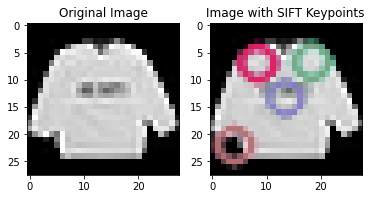

In [15]:
image = train.iloc[0, 1:].values.reshape(28, 28).astype(np.uint8)

'''
astype(np.uint8)
This is a NumPy data type representing unsigned 8-bit integers. The range of values for uint8 is typically 0 to 255.
SIFT implementation, which expects pixel values to be in the uint8 range
Pixel values are often represented as integers in the range [0, 255].
'''
# Initialize SIFT detector
sift = cv2.SIFT_create()

# Detect SIFT features
keypoints, descriptors = sift.detectAndCompute(image, None)
'''
The mask is used to specify a region in the image where keypoint detection should be performed. 
If None is passed as the mask, the entire image is considered.
'''

# Visualize SIFT keypoints on the image
image_with_keypoints = cv2.drawKeypoints(image, keypoints, None)
'''
the third argument represents the output image where the keypoints will be drawn.
If you pass None as the output image, the function will create a new output image with the same size as the input image,
and it will draw the keypoints on this new image. 
'''

# the original image 
plt.subplot(1, 2, 1)
plt.imshow(image, cmap='gray')
plt.title('Original Image')

# the image with keypoints
plt.subplot(1, 2, 2)
plt.imshow(image_with_keypoints, cmap='gray')
plt.title('Image with SIFT Keypoints')

plt.show()


In [16]:
descriptors, descriptors.shape

(array([[ 0.,  0.,  0., ...,  0.,  1.,  2.],
        [ 1., 16.,  2., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  0.,  1.],
        ...,
        [ 0.,  0.,  0., ...,  0.,  0.,  0.],
        [ 0.,  0.,  0., ...,  0.,  1.,  3.],
        [ 2.,  0.,  0., ...,  0.,  0.,  0.]], dtype=float32),
 (8, 128))

<h2 id="4.1" style="color:skyblue"> SIFT is not suitable for our problem </h2> 
Sift can be good for 
- Object detection
- image matching
- Large images 
It's bad in our case because the image size is small 28*28
some images won't have any features at all 

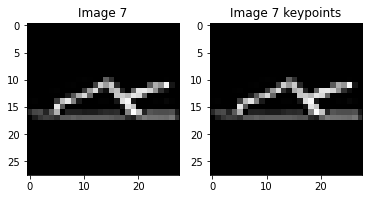

In [17]:
# SIFT is not suitable for this problem as some images SIFT won't be able to extract any keypoint therfore we can' use it for the whole dataset 
# this due to that mostly the small size of the images we are dealing with 28×28

# Initialize SIFT detector
sift = cv2.SIFT_create()

image7 = train.iloc[7 ,1:].values.reshape(28,28).astype(np.uint8)
keypoints7, descriptors7 = sift.detectAndCompute(image7, None)
# visualize the SIFT
image_with_keypoints7 = cv2.drawKeypoints(image7, keypoints7, None)
# to plot the two side by side
plt.subplot(1, 2, 1)
plt.imshow(image7, cmap="gray")
plt.title('Image 7')

plt.subplot(1, 2, 2)
plt.imshow(image_with_keypoints7, cmap="gray")
plt.title('Image 7 keypoints')

plt.show()

<h1 id="5" style="color:salmon">PCA</h1>

In [34]:
# PCA
def do_pca(n_component, dataset, pca_object=None):
    X = StandardScaler().fit_transform(dataset)
    
    if pca_object is None:
        # If no PCA object is provided, create a new one
        pca = PCA(n_components=n_component)
        x_pca = pca.fit_transform(X)
        return pca, x_pca
    else:
        # Use the provided PCA object to transform the data
        x_pca = pca_object.transform(X)
        return pca_object, x_pca

In [35]:
pca40, x_40pca = do_pca(40, train.drop(columns="label"))
x_40pca.shape

(60000, 40)

In [36]:
train_pca40_df = pd.DataFrame(x_40pca)
train_pca40_df.head()

0          1         2          3         4         5         6   \
0  10.664973  14.993363 -0.689468 -10.980911  4.788254  0.559623  2.141115   
1 -11.989748  11.812770 -5.801049  -3.418629 -4.630650  2.061772 -3.109565   
2  20.517671   1.579784  6.770122  -2.884371 -5.379185  2.618096 -0.246181   
3   9.634535  -6.790917 -0.907860   4.577228  8.377438 -0.094376 -8.672806   
4  11.493442 -11.655488 -7.208334  -4.772964 -0.594114  0.553685  0.388620   

         7         8         9   ...        30        31        32        33  \
0 -2.582798 -4.525370 -0.758689  ... -1.530579  1.394830 -2.278333 -2.294341   
1 -3.308504 -4.461980  5.669063  ... -0.467369  1.778804 -0.102749  0.320264   
2 -2.936941  3.415352 -1.236736  ...  0.260708 -0.345817 -0.378379  0.305361   
3 -0.604500 -2.566944 -3.070932  ...  0.635726  1.108873  0.650098 -0.662520   
4 -0.384219  2.063611 -4.824827  ... -1.518739 -1.130757  0.420996 -2.294038   

         34        35        36        37        38        39  
0 -2.454768 -2.905128 -1.991745  0.108772 -1.531449  4.137939  
1  1.653639 -2.177671  1.208585 -2.240644  0.649311 -1.785557  
2  0.547448  0.535585 -0.082853 -0.491304  0.785215 -1.202624  
3 -1.287922  2.529832  1.885708  0.995510  0.101587  2.176586  
4  0.773056 -2.698066  2.177149  1.082523  0.384146  0.839651  

[5 rows x 40 columns]

In [37]:
train_pca40_df["label"] = train["label"]
train_pca40_df.sample(10)

0          1          2          3          4         5  \
45954   3.816967 -15.045483 -11.432617  -2.215295  -2.067356 -1.942662   
46397  -2.993289 -14.921694  -2.499602   1.320474   0.964920 -0.533197   
7393  -16.301334   7.277430  -2.061911 -12.689121  -0.202719  4.000579   
58917  12.666677   2.312412   7.299886  -3.826725  -6.174844 -2.098555   
58927  -5.103257  -6.170283   7.930277   1.029458  -2.891644 -1.879966   
8285    8.171837 -16.584464 -12.381557  -2.046780  -1.712936 -0.100654   
28945  -3.626410   0.193399  10.410738   7.614089  -0.002257 -4.959784   
49131  19.206903   1.223993   3.268555  -6.104880  -6.820946  1.539621   
49987  17.764961  -8.001019  -3.661750   4.921007  10.130908  4.300452   
48241   2.896924 -13.857738  -4.137600  -0.556850   0.325869  2.700419   

               6         7         8         9  ...        31        32  \
45954   2.948806  3.583923 -0.186803 -0.825471  ... -1.969961  1.497406   
46397   1.744293  0.845952 -1.750808 -0.524676  ...  0.238381  0.035509   
7393   -3.512831  9.307417  1.920172  0.612224  ... -0.074696 -0.364657   
58917  -0.534115 -4.127841  4.284826 -0.330161  ... -0.878804 -1.202425   
58927   1.879922 -4.914665  4.070091 -0.866247  ...  1.084237 -0.993839   
8285    3.620851  3.525044 -2.003485  0.736981  ...  1.310694  1.260443   
28945   1.974201  3.993467 -6.462746  1.666847  ...  0.399909  1.071290   
49131   1.600244 -3.918386  6.160908  1.858873  ... -0.362722 -0.570963   
49987 -10.174927 -0.349316 -4.050973 -3.647076  ...  0.166816 -0.082016   
48241   4.795114 -0.591453  0.465959 -3.081179  ...  0.081637 -1.642617   

             33        34        35        36        37        38        39  \
45954  1.288385 -0.384854 -1.695363  1.090369  0.236261  1.558642 -1.816098   
46397  0.169206 -0.532194  0.724283  1.325369  1.273202  0.392425 -0.451845   
7393  -0.163625  0.892516  0.880084 -1.520904  2.272959  0.715802 -0.774750   
58917  1.309353 -1.047914 -0.246533 -0.222380  0.547684 -1.098209 -1.752506   
58927 -2.170666  0.292729 -0.848171  0.750212  1.631909 -0.944755  1.259197   
8285   2.692255 -1.461029  2.148789  1.108846  1.011349 -0.420167 -1.267154   
28945 -3.175644 -1.299571 -0.535473  1.961313  1.081862 -2.070392 -0.718434   
49131  0.902785  0.319701  0.766548  0.056661  0.747748 -0.365733 -0.890785   
49987  0.275468 -0.082752  0.503637  2.099714 -0.188140  0.609739  2.474356   
48241 -1.890940  0.691679 -0.780065 -0.944880 -1.221072 -0.184878  0.147792   

       label  
45954      3  
46397      3  
7393       7  
58917      4  
58927      4  
8285       3  
28945      2  
49131      4  
49987      0  
48241      3  

[10 rows x 41 columns]

In [38]:
# pca for test data
# using the same pca object fitted on the train data on the test and any new data⚠️ 'pca40' 
pca40_test, x_40pca_test = do_pca(40, test.drop(columns="label"), pca_object=pca40)

# pca test to dataframe 
test_pca40_df = pd.DataFrame(x_40pca_test)

# adding the label 
test_pca40_df["label"] = test["label"]

# displaying
display(test_pca40_df.shape, test_pca40_df.sample(10))


(10000, 41)

0          1          2          3         4          5  \
3950  12.491267  -8.919156  -1.015506   0.639044 -0.769745   8.014303   
599   -5.673673 -15.479375  -4.478663   0.793542 -0.857383  -4.771925   
6027 -11.075632  -7.853777   7.010630   4.701174 -0.870820   2.099006   
7073  -1.506446   8.129293   5.094744  10.662890 -4.443421  11.801086   
9396  -4.161769  -3.180841  10.446328   1.388504 -3.382018  -0.711250   
7155  21.995762  -6.479602  -6.576288   1.117612  7.150219   2.714014   
9135   9.386479   4.597838  10.134200  -1.321134 -5.206329  -4.125802   
6707  -7.614262  -7.849929   5.925634   4.470513  3.878417   1.094840   
1889  -0.638380 -17.439233  -7.084809  -1.014973 -0.816928  -8.000223   
5919  -4.434767  18.200838 -10.511454  15.726629 -5.873962  -1.091511   

              6          7         8         9  ...        31        32  \
3950  -0.706249   1.039074  1.867099  5.646174  ...  1.436932  0.488417   
599    6.003340   0.035634 -1.887632  2.584079  ...  0.321038 -0.779281   
6027   0.628257  -2.271020  1.538262  0.751049  ...  1.213481  0.945794   
7073  12.959200  10.624247 -5.383149  0.333838  ... -3.078071  1.139375   
9396   0.297079  -3.794609  3.614788 -0.176936  ...  0.800279 -0.407361   
7155  -8.953346  -0.987446 -1.270128 -6.689852  ... -0.997380 -1.581649   
9135  -0.771209  -1.761381  1.499066 -0.839400  ... -0.335465 -0.015227   
6707  -1.909652  -2.387156 -1.806411 -2.090291  ... -0.512628  0.976506   
1889   6.178521   1.912973 -1.988931  3.968210  ... -0.367252 -2.265625   
5919   0.059197  -3.275873  3.068294 -1.143160  ...  3.084497  3.139802   

            33        34        35        36        37        38        39  \
3950  0.720389 -0.136462  2.038682  0.263983 -1.845687  0.758568 -0.465184   
599  -0.686916 -0.829398  0.334676 -0.750795 -0.534536  0.243275  0.814313   
6027  0.647275 -0.145024  0.711631 -0.444960 -0.250148 -0.238956  0.815060   
7073 -0.260389 -1.296223 -1.032501  2.420492  2.770760 -2.474631  1.956285   
9396  0.588879 -0.689376 -0.637828  1.387381  0.759994 -0.359206  0.329979   
7155 -0.692406  0.106245 -0.948942  2.850155  0.561384  1.606767  1.400688   
9135 -0.363929 -0.566602 -1.121378  0.207304 -0.964414  2.067460  0.251617   
6707  0.161402 -0.517805 -1.997363 -1.081776 -0.723980 -0.539671 -0.467162   
1889 -2.144512  1.004764 -0.719945 -1.560400 -1.645817  1.356954  0.942831   
5919 -1.338689  1.418582 -3.654758 -4.360556  3.822772  0.671881  0.870600   

      label  
3950      3  
599       1  
6027      6  
7073      8  
9396      4  
7155      0  
9135      2  
6707      6  
1889      1  
5919      9  

[10 rows x 41 columns]

In [39]:
# SAVING THE FEATURES FOR FUTURE USE 
# train_hog_df.to_csv("features_sets/train_hog.csv")
# test_hog_df.to_csv("features_sets/test_hog.csv")
# train_pca40_df.to_csv("features_sets/train_pca40.csv")
# test_pca40_df.to_csv("features_sets/test_pca40.csv")

<h2 style="color:skyblue" id="6"> Scaling the Pixel values </h2>

In [6]:
train_scaled = train.drop(columns="label")/255
test_scaled = test.drop(columns="label")/255 

In [7]:
train_scaled["label"] = train["label"]
test_scaled["label"] = test["label"]

In [25]:
train_scaled.head()

pixel1  pixel2  pixel3    pixel4    pixel5  pixel6  pixel7    pixel8  \
0     0.0     0.0     0.0  0.000000  0.000000     0.0     0.0  0.000000   
1     0.0     0.0     0.0  0.000000  0.000000     0.0     0.0  0.000000   
2     0.0     0.0     0.0  0.000000  0.000000     0.0     0.0  0.019608   
3     0.0     0.0     0.0  0.003922  0.007843     0.0     0.0  0.000000   
4     0.0     0.0     0.0  0.000000  0.000000     0.0     0.0  0.000000   

   pixel9  pixel10  ...  pixel776  pixel777  pixel778  pixel779  pixel780  \
0     0.0      0.0  ...       0.0       0.0  0.000000  0.000000  0.000000   
1     0.0      0.0  ...       0.0       0.0  0.000000  0.000000  0.000000   
2     0.0      0.0  ...       0.0       0.0  0.117647  0.168627  0.000000   
3     0.0      0.0  ...       0.0       0.0  0.000000  0.000000  0.003922   
4     0.0      0.0  ...       0.0       0.0  0.000000  0.000000  0.000000   

   pixel781  pixel782  pixel783  pixel784  label  
0       0.0       0.0       0.0       0.0      2  
1       0.0       0.0       0.0       0.0      9  
2       0.0       0.0       0.0       0.0      6  
3       0.0       0.0       0.0       0.0      0  
4       0.0       0.0       0.0       0.0      3  

[5 rows x 785 columns]

<h1 style="color:salmon" id="7">Models</h1>

In [8]:
# Spliting the data
def split_df(df_train, df_test):
    X_train = df_train.drop(columns = "label")
    y_train = df_train["label"]
    X_test = df_test.drop(columns = "label")
    y_test = df_test["label"]
    return X_train, X_test, y_train, y_test

In [40]:
# Spliting for Pixel Value dataset 🟢
X_train_px, X_test_px, y_train_px, y_test_px = split_df(train_scaled, test_scaled)
# Spliting for Hog 🔵
X_train_hog, X_test_hog, y_train_hog, y_test_hog = split_df(train_hog_df, test_hog_df)
# Spliting for PCA 🔴
X_train_40pca, X_test_40pc, y_train_40pca, y_test_40pca = split_df(train_pca40_df, test_pca40_df)

<h2 id="72" style="color:lightgreen"> Logistic Regression for Pixel Value dataset 🟢 </h2>

You can use Logistic regression for multi-classification problem by one of the two ways:
| multi-class =’ovr’ | multi-class =’multinomial’ |
| --- | --- |
| one-vs-rest (OvR) scheme | use cross-entropy loss |
|  | supported only by the ‘lbfgs’, ‘sag’, ‘saga’ and ‘newton-cg’ solvers. |


>OvR: separate binary classifier is trained to distinguish that class from all the other classes combined. So, if you have K classes, you train K binary classifiers.

>The prediction is then made by running all K classifiers on a test instance and selecting the class for which the corresponding classifier gives the highest confidence or probability.


| multiclass | binary |
| --- | --- |
| ‘newton-cg’‘sag’‘saga’‘lbfgs’  handle mutinomial loss, auto, multinomial | OvR, auto |

```python
if auto is set :
	if liblinear or binary:
		select OvR
	else:
		select multinomial
```

Penality and solvers


`elasticnet`: both L1 and L2 penalty terms are added
| l1 | l2 | elasticnet | None |
| --- | --- | --- | --- |
| ‘liblinear’‘saga’ | ‘lbfgs’ ‘liblinear’‘newton-cg’‘sag’‘saga’ | only with saga | ‘lbfgs’‘newton-cg’‘sag’‘saga’ |


Large dataset Vs Small datasets Solvers
| Small datasets | Large datesets |
| --- | --- |
|  ‘liblinear’ | ‘sag’‘saga’ |


https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html







1. **'lbfgs' (Limited-memory Broyden–Fletcher–Goldfarb–Shanno):**
    - This solver is based on quasi-Newton methods.
    - It belongs to the family of iterative optimization algorithms that aim to find the minimum of a function.
    - It uses an approximation of the inverse Hessian matrix to update the weights iteratively.
2. **'liblinear':**
    - Uses a coordinate descent algorithm.
    - Applies a variant of the Newton-Raphson method for logistic regression.
    - Suitable for small to medium-sized datasets and is efficient for high-dimensional data.
3. **'newton-cg' (Newton-Conjugate Gradient):**
    - Uses a Newton-CG optimization algorithm.
    - Handles multinomial loss for multiclass problems.
    - It iteratively applies the Newton-Raphson method along the conjugate gradient direction to find the optimal weights.
4. **'sag' (Stochastic Average Gradient):**
    - Applies a stochastic optimization algorithm.
    - Particularly well-suited for large datasets.
    - Uses a stochastic approximation of the true gradient.
5. **'saga' (SAGA - Stochastic Average Gradient Descent):**
    - An improved version of 'sag'.
    - Supports L1 regularization in addition to L2 regularization.
    - Uses a faster variant of the SAG algorithm.
6. **'newton-cholesky':**
    - Applicable when there are many more samples than features.
    - Limited to binary classification and the one-versus-rest reduction for multiclass classification.
    - Computes the Hessian matrix using the Cholesky decomposition method.

> We have a multi_class problem with a larg dataset 60k samples, we scaled the data (pre-condition), and we can use OvR or multinomial, OvR would make 9 classifiers as we had 9 classes, and multinomial use one classifier and minimize the mutli-class loss such as Cross-Entropy (log-loss) anyway the 'auto' option would deal with this as some solvers won't work with some options.

> Solvers we may use 
- libfgs ❌ slow, not suitable for larg datasets (default)
- liblinear ❌ slow, not suitable for larg datasets
- newton-cg ✅ let's give it a try 
- sag ✅ good but ..saga is faster
- saga ✅ let's give it a try 
- newton-cholesky ❌ prefered when (samples (rows=60k) >> features (cols=0.785k)) but calculate Hessian may make it slow

In [31]:
# creating a model 
# when using the default max_iter it didn't converge but we got 85%~86%
# the default solver doesn't converge 
# lower numbe of iterations is faster and give quite the same accuracy 
logReg = LogisticRegression(solver='saga', max_iter=3)

# fitting the model
logReg.fit(X_train_px, y_train_px)

# scoring the model 
print(f"Train score {logReg.score(X_train_px, y_train_px)}")
print(f"Test score {logReg.score(X_test_px, y_test_px)}")
print(f"Cross Validation {cross_val_score(logReg, X_train_px, y_train_px, cv=5, n_jobs=-1).mean()}")

# train 0.860
# test 0.857
# Cross validation 0.853

c:\Users\msi\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge

  warnings.warn(


Train score 0.8609

Test score 0.8571

Cross Validation 0.8535666666666668


In [35]:
logRegCV = LogisticRegression(max_iter=1)

# params to try
params = {
    'C' : [10, 100, 0.1],
    'solver': ['saga', 'newton-cg']
}

# Grid Search
gridSearch = GridSearchCV(logRegCV, params, cv=3, n_jobs=-1)

# Fit the grid search to the data
gridSearch.fit(X_train_px, y_train_px)

# Print the best hyperparameters and corresponding accuracy
print("Best Hyperparameters:", gridSearch.best_params_)
print("Best Cross-Validated Accuracy:", gridSearch.best_score_)

Best Hyperparameters: {'C': 100, 'solver': 'saga'}

Best Cross-Validated Accuracy: 0.8376833333333334


c:\Users\msi\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge

  warnings.warn(


In [37]:
logistic_GS1 = pd.DataFrame(gridSearch.cv_results_)
logistic_GS1

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0      51.650004     18.166797         6.444305        5.441238      10   
1      64.954817      8.975585        12.613929       17.473735      10   
2      66.090613     10.498844         1.994384        1.764024     100   
3      83.474869     10.811843         0.146370        0.009805     100   
4       2.262331      0.808139         0.055866        0.007040     0.1   
5       1.684600      0.678552         0.066497        0.022108     0.1   

  param_solver                             params  split0_test_score  \
0         saga        {'C': 10, 'solver': 'saga'}            0.83475   
1    newton-cg   {'C': 10, 'solver': 'newton-cg'}            0.62820   
2         saga       {'C': 100, 'solver': 'saga'}            0.83835   
3    newton-cg  {'C': 100, 'solver': 'newton-cg'}            0.62820   
4         saga       {'C': 0.1, 'solver': 'saga'}            0.83315   
5    newton-cg  {'C': 0.1, 'solver': 'newton-cg'}            0.62820   

   split1_test_score  split2_test_score  mean_test_score  std_test_score  \
0            0.83550            0.84055         0.836933        0.002576   
1            0.61860            0.62985         0.625550        0.004960   
2            0.84145            0.83325         0.837683        0.003381   
3            0.61860            0.62985         0.625550        0.004960   
4            0.83565            0.83810         0.835633        0.002021   
5            0.61860            0.62985         0.625550        0.004960   

   rank_test_score  
0                2  
1                4  
2                1  
3                4  
4                3  
5                4

In [41]:
logRegCV = LogisticRegression(max_iter=1, solver='saga')

# params to try
params = {
    'C' : [10, 100, 0.1],
    'multi_class': ['ovr', 'multinomial']
}

# Grid Search
gridSearch = GridSearchCV(logRegCV, params,scoring='accuracy', cv=3, n_jobs=-1)

# Fit the grid search to the data
gridSearch.fit(X_train_px, y_train_px)

# Print the best hyperparameters and corresponding accuracy
print("Best Hyperparameters:", gridSearch.best_params_)
print("Best Cross-Validated Accuracy:", gridSearch.best_score_)

c:\Users\msi\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge

  warnings.warn(


Best Hyperparameters: {'C': 10, 'multi_class': 'multinomial'}

Best Cross-Validated Accuracy: 0.8422000000000001


In [42]:
logistic_GS2 = pd.DataFrame(gridSearch.cv_results_)
logistic_GS2

mean_fit_time  std_fit_time  mean_score_time  std_score_time param_C  \
0      76.765552     26.250199        11.058055       12.463511      10   
1      46.081321     10.174020        11.855125       15.354947      10   
2      90.496409     26.065734        24.121629       14.203526     100   
3      84.427474     32.283194         5.834922        4.511639     100   
4       6.666688      3.050470         1.006514        0.675813     0.1   
5       4.678921      3.298911         0.088086        0.046193     0.1   

  param_multi_class                                    params  \
0               ovr           {'C': 10, 'multi_class': 'ovr'}   
1       multinomial   {'C': 10, 'multi_class': 'multinomial'}   
2               ovr          {'C': 100, 'multi_class': 'ovr'}   
3       multinomial  {'C': 100, 'multi_class': 'multinomial'}   
4               ovr          {'C': 0.1, 'multi_class': 'ovr'}   
5       multinomial  {'C': 0.1, 'multi_class': 'multinomial'}   

   split0_test_score  split1_test_score  split2_test_score  mean_test_score  \
0            0.83640            0.82940            0.83750         0.834433   
1            0.84260            0.84195            0.84205         0.842200   
2            0.82970            0.82315            0.83265         0.828500   
3            0.83950            0.82415            0.84125         0.834967   
4            0.83225            0.83575            0.82885         0.832283   
5            0.84075            0.83675            0.84145         0.839650   

   std_test_score  rank_test_score  
0        0.003587                4  
1        0.000286                1  
2        0.003970                6  
3        0.007682                3  
4        0.002817                5  
5        0.002070                2

In [43]:
# let's build a better model 
logRegFinal = LogisticRegression(C=10, max_iter=3, solver='saga')

# fitting the model
logRegFinal.fit(X_train_px, y_train_px)

# scoring the model 
print(f"Train score {logRegFinal.score(X_train_px, y_train_px)}")
print(f"Test score {logRegFinal.score(X_test_px, y_test_px)}")

c:\Users\msi\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge

  warnings.warn(


Train score 0.8631666666666666

Test score 0.8574


In [46]:
cv_score = cross_val_score(logRegFinal, X_train_px, y_train_px, cv=6, scoring="accuracy",  n_jobs=-1)
print(f"Cross Validation 6 folds {cv_score}")

Cross Validation 6 folds [0.8565 0.8534 0.857  0.8511 0.8488 0.8507]


In [47]:
# mean cross validation 
print(f"mean cross validation for 6 folds {cv_score.mean()}")

mean cross validation for 6 folds 0.8529166666666667


In [48]:
# saving model result 
logistic_GS1.to_csv('gridSearch_Logistic_Choose_Solver.csv')
logistic_GS2.to_csv('gridSearch_Logistic_choose_Multiclass.csv')

<h2 id="7.2" style="color:lightblue" >Logistic Regression for Hog dataset 🔵 </h2>

In [50]:
logRegHog = LogisticRegression(solver='saga')

# fitting on Hog
logRegHog.fit(X_train_hog, y_train_hog)

# scoring
print(f"Train score {logRegHog.score(X_train_hog, y_train_hog)}")
print(f"Test score {logRegHog.score(X_test_hog, y_test_hog)}")
print(f"Cross Validation {cross_val_score(logRegHog, X_train_hog, y_train_hog, cv=6, n_jobs=-1).mean()}")

Train score 0.81395

Test score 0.8144

Cross Validation 0.8107000000000001


<h2 id="73" style="color:red">Logistic Regression for PCA dataset 🔴</h2>

In [57]:
logRegPca40 = LogisticRegression(solver='saga')

# fitting on pca 40 features only 
logRegPca40.fit(X_train_40pca, y_train_40pca)

# scoring 
print(f"Train score {logRegPca40.score(X_train_40pca, y_train_40pca)}")
print(f"Test score {logRegPca40.score(X_test_40pc, y_test_40pca)}")
print(f"Cross Validation {cross_val_score(logRegPca40 , X_train_40pca, y_train_40pca, cv=6, n_jobs=-1).mean()}")


c:\Users\msi\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge

  warnings.warn(


Train score 0.8199666666666666

Test score 0.8208

Cross Validation 0.8182666666666666


<h2 id="74" style="color:purple">SO how about a combo dataset 😯</h2>

### mix1 (PCA🔴+HoG🔵) 🟣 

In [61]:
pca40_cols_names = ["pca"+str(i) for i in range(40)]
pca40_cols_names.append("label")
np.array(pca40_cols_names)

array(['pca0', 'pca1', 'pca2', 'pca3', 'pca4', 'pca5', 'pca6', 'pca7',
       'pca8', 'pca9', 'pca10', 'pca11', 'pca12', 'pca13', 'pca14',
       'pca15', 'pca16', 'pca17', 'pca18', 'pca19', 'pca20', 'pca21',
       'pca22', 'pca23', 'pca24', 'pca25', 'pca26', 'pca27', 'pca28',
       'pca29', 'pca30', 'pca31', 'pca32', 'pca33', 'pca34', 'pca35',
       'pca36', 'pca37', 'pca38', 'pca39', 'label'], dtype='<U5')

In [62]:
train_pca40_df

0          1          2          3         4          5  \
0      10.664973  14.993363  -0.689468 -10.980911  4.788254   0.559623   
1     -11.989748  11.812770  -5.801049  -3.418629 -4.630650   2.061772   
2      20.517671   1.579784   6.770122  -2.884371 -5.379185   2.618096   
3       9.634535  -6.790917  -0.907860   4.577228  8.377438  -0.094376   
4      11.493442 -11.655488  -7.208334  -4.772964 -0.594114   0.553685   
...          ...        ...        ...        ...       ...        ...   
59995   0.871480  15.580971 -11.665720   9.018102 -7.432314  -3.170016   
59996 -10.172701 -14.933856  -0.769995   3.220531 -0.104116  -1.231324   
59997   7.148767  -0.543565  -0.874060  -1.501746 -6.148917  18.263320   
59998   4.434153  20.832704  -0.576302  -0.035641  2.830417   4.867025   
59999  -9.106810  14.831154  -3.674678 -17.990272  1.674156   3.622778   

               6         7         8         9  ...        31        32  \
0       2.141115 -2.582798 -4.525370 -0.758689  ...  1.394830 -2.278333   
1      -3.109565 -3.308504 -4.461980  5.669063  ...  1.778804 -0.102749   
2      -0.246181 -2.936941  3.415352 -1.236736  ... -0.345817 -0.378379   
3      -8.672806 -0.604500 -2.566944 -3.070932  ...  1.108873  0.650098   
4       0.388620 -0.384219  2.063611 -4.824827  ... -1.130757  0.420996   
...          ...       ...       ...       ...  ...       ...       ...   
59995  -3.461792 -4.493587 -1.647476 -1.947253  ...  1.707118 -0.279537   
59996   5.674792 -0.981362 -2.317313  2.047081  ...  1.028604 -0.399787   
59997   2.234245 -2.135960  3.729180  2.975972  ... -0.160462  1.957272   
59998  11.700803 -0.857599 -2.728543 -1.727853  ... -0.481317  0.752522   
59999  -0.731142  8.279519  0.662844  1.307257  ...  0.828238 -2.007101   

             33        34        35        36        37        38        39  \
0     -2.294341 -2.454768 -2.905128 -1.991745  0.108772 -1.531449  4.137939   
1      0.320264  1.653639 -2.177671  1.208585 -2.240644  0.649311 -1.785557   
2      0.305361  0.547448  0.535585 -0.082853 -0.491304  0.785215 -1.202624   
3     -0.662520 -1.287922  2.529832  1.885708  0.995510  0.101587  2.176586   
4     -2.294038  0.773056 -2.698066  2.177149  1.082523  0.384146  0.839651   
...         ...       ...       ...       ...       ...       ...       ...   
59995 -2.037324 -1.481732  1.384719 -1.299551  1.710073  0.912532 -0.999123   
59996 -1.331761  0.134395  0.215844 -0.236633  0.677435  0.241687  0.382365   
59997  0.225077 -2.856422 -0.408680  1.309657 -0.656813  1.339639 -0.611365   
59998 -0.569092  1.405320 -0.296658  5.278235  1.864252 -0.877512 -2.754262   
59999 -0.714396 -5.043957  0.961686  0.250317  1.567338  0.288167  1.756768   

       label  
0          2  
1          9  
2          6  
3          0  
4          3  
...      ...  
59995      9  
59996      1  
59997      8  
59998      8  
59999      7  

[60000 rows x 41 columns]

In [63]:
# renaming the columns to prepare for mixing
train_pca40_df.rename(columns=dict(zip(train_pca40_df.columns, pca40_cols_names)), inplace=True)

In [64]:
train_pca40_df.head(3)

pca0       pca1      pca2       pca3      pca4      pca5      pca6  \
0  10.664973  14.993363 -0.689468 -10.980911  4.788254  0.559623  2.141115   
1 -11.989748  11.812770 -5.801049  -3.418629 -4.630650  2.061772 -3.109565   
2  20.517671   1.579784  6.770122  -2.884371 -5.379185  2.618096 -0.246181   

       pca7      pca8      pca9  ...     pca31     pca32     pca33     pca34  \
0 -2.582798 -4.525370 -0.758689  ...  1.394830 -2.278333 -2.294341 -2.454768   
1 -3.308504 -4.461980  5.669063  ...  1.778804 -0.102749  0.320264  1.653639   
2 -2.936941  3.415352 -1.236736  ... -0.345817 -0.378379  0.305361  0.547448   

      pca35     pca36     pca37     pca38     pca39  label  
0 -2.905128 -1.991745  0.108772 -1.531449  4.137939      2  
1 -2.177671  1.208585 -2.240644  0.649311 -1.785557      9  
2  0.535585 -0.082853 -0.491304  0.785215 -1.202624      6  

[3 rows x 41 columns]

In [65]:
train_hog_df.head(3)

0         1         2         3         4         5         6  \
0  0.057845  0.194040  0.207260  0.068280  0.058807  0.000489  0.000000   
1  0.000394  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2  0.257989  0.225401  0.105295  0.028898  0.009615  0.000000  0.001612   

          7         8        9  ...        63        64        65        66  \
0  0.003777  0.011969  0.08460  ...  0.014512  0.237629  0.067363  0.006902   
1  0.000000  0.001181  0.00000  ...  0.030951  0.041209  0.020112  0.198062   
2  0.013724  0.083109  0.16678  ...  0.059946  0.290640  0.022658  0.068237   

         67        68        69        70        71  label  
0  0.041049  0.087453  0.201157  0.081416  0.065727      2  
1  0.270952  0.259899  0.092271  0.074821  0.047910      9  
2  0.000000  0.022346  0.039562  0.020390  0.290640      6  

[3 rows x 73 columns]

In [66]:
hog_cols_names = ["hog"+str(i) for i in range(72)]
hog_cols_names.append("label")
np.array(hog_cols_names)

array(['hog0', 'hog1', 'hog2', 'hog3', 'hog4', 'hog5', 'hog6', 'hog7',
       'hog8', 'hog9', 'hog10', 'hog11', 'hog12', 'hog13', 'hog14',
       'hog15', 'hog16', 'hog17', 'hog18', 'hog19', 'hog20', 'hog21',
       'hog22', 'hog23', 'hog24', 'hog25', 'hog26', 'hog27', 'hog28',
       'hog29', 'hog30', 'hog31', 'hog32', 'hog33', 'hog34', 'hog35',
       'hog36', 'hog37', 'hog38', 'hog39', 'hog40', 'hog41', 'hog42',
       'hog43', 'hog44', 'hog45', 'hog46', 'hog47', 'hog48', 'hog49',
       'hog50', 'hog51', 'hog52', 'hog53', 'hog54', 'hog55', 'hog56',
       'hog57', 'hog58', 'hog59', 'hog60', 'hog61', 'hog62', 'hog63',
       'hog64', 'hog65', 'hog66', 'hog67', 'hog68', 'hog69', 'hog70',
       'hog71', 'label'], dtype='<U5')

In [67]:
train_hog_df.rename(columns=dict(zip(train_hog_df.columns, hog_cols_names)), inplace=True)

In [68]:
train_hog_df.head(3)

hog0      hog1      hog2      hog3      hog4      hog5      hog6  \
0  0.057845  0.194040  0.207260  0.068280  0.058807  0.000489  0.000000   
1  0.000394  0.000000  0.000000  0.000000  0.000000  0.000000  0.000000   
2  0.257989  0.225401  0.105295  0.028898  0.009615  0.000000  0.001612   

       hog7      hog8     hog9  ...     hog63     hog64     hog65     hog66  \
0  0.003777  0.011969  0.08460  ...  0.014512  0.237629  0.067363  0.006902   
1  0.000000  0.001181  0.00000  ...  0.030951  0.041209  0.020112  0.198062   
2  0.013724  0.083109  0.16678  ...  0.059946  0.290640  0.022658  0.068237   

      hog67     hog68     hog69     hog70     hog71  label  
0  0.041049  0.087453  0.201157  0.081416  0.065727      2  
1  0.270952  0.259899  0.092271  0.074821  0.047910      9  
2  0.000000  0.022346  0.039562  0.020390  0.290640      6  

[3 rows x 73 columns]

In [69]:
mix1 = pd.concat([train_pca40_df.drop(columns="label"), train_hog_df], axis=1)
mix1

pca0       pca1       pca2       pca3      pca4       pca5  \
0      10.664973  14.993363  -0.689468 -10.980911  4.788254   0.559623   
1     -11.989748  11.812770  -5.801049  -3.418629 -4.630650   2.061772   
2      20.517671   1.579784   6.770122  -2.884371 -5.379185   2.618096   
3       9.634535  -6.790917  -0.907860   4.577228  8.377438  -0.094376   
4      11.493442 -11.655488  -7.208334  -4.772964 -0.594114   0.553685   
...          ...        ...        ...        ...       ...        ...   
59995   0.871480  15.580971 -11.665720   9.018102 -7.432314  -3.170016   
59996 -10.172701 -14.933856  -0.769995   3.220531 -0.104116  -1.231324   
59997   7.148767  -0.543565  -0.874060  -1.501746 -6.148917  18.263320   
59998   4.434153  20.832704  -0.576302  -0.035641  2.830417   4.867025   
59999  -9.106810  14.831154  -3.674678 -17.990272  1.674156   3.622778   

            pca6      pca7      pca8      pca9  ...     hog63     hog64  \
0       2.141115 -2.582798 -4.525370 -0.758689  ...  0.014512  0.237629   
1      -3.109565 -3.308504 -4.461980  5.669063  ...  0.030951  0.041209   
2      -0.246181 -2.936941  3.415352 -1.236736  ...  0.059946  0.290640   
3      -8.672806 -0.604500 -2.566944 -3.070932  ...  0.166557  0.127487   
4       0.388620 -0.384219  2.063611 -4.824827  ...  0.253988  0.265136   
...          ...       ...       ...       ...  ...       ...       ...   
59995  -3.461792 -4.493587 -1.647476 -1.947253  ...  0.004593  0.102718   
59996   5.674792 -0.981362 -2.317313  2.047081  ...  0.339419  0.205678   
59997   2.234245 -2.135960  3.729180  2.975972  ...  0.004171  0.118615   
59998  11.700803 -0.857599 -2.728543 -1.727853  ...  0.019115  0.005020   
59999  -0.731142  8.279519  0.662844  1.307257  ...  0.001989  0.000000   

          hog65     hog66     hog67     hog68     hog69     hog70     hog71  \
0      0.067363  0.006902  0.041049  0.087453  0.201157  0.081416  0.065727   
1      0.020112  0.198062  0.270952  0.259899  0.092271  0.074821  0.047910   
2      0.022658  0.068237  0.000000  0.022346  0.039562  0.020390  0.290640   
3      0.056144  0.091727  0.088432  0.046796  0.080052  0.097072  0.205857   
4      0.000772  0.000244  0.000546  0.002763  0.000000  0.000867  0.166677   
...         ...       ...       ...       ...       ...       ...       ...   
59995  0.075770  0.098511  0.263135  0.061170  0.034932  0.040422  0.037220   
59996  0.044807  0.000000  0.000000  0.000000  0.000000  0.075193  0.339419   
59997  0.124222  0.068585  0.023400  0.110945  0.075632  0.109533  0.256241   
59998  0.001957  0.045760  0.075126  0.121449  0.020939  0.031096  0.008488   
59999  0.000000  0.012389  0.282962  0.282962  0.001673  0.000000  0.007983   

       label  
0          2  
1          9  
2          6  
3          0  
4          3  
...      ...  
59995      9  
59996      1  
59997      8  
59998      8  
59999      7  

[60000 rows x 113 columns]

In [70]:
# saving the mix dataset 
# mix1.to_csv("features_sets/mixPCAHOG.csv")

In [71]:
mix1.describe()

pca0          pca1          pca2          pca3          pca4  \
count  6.000000e+04  6.000000e+04  6.000000e+04  6.000000e+04  6.000000e+04   
mean  -7.455962e-16  2.027415e-16 -9.189686e-17  3.505344e-17 -1.383190e-15   
std    1.315033e+01  1.062370e+01  6.541997e+00  6.333501e+00  5.648330e+00   
min   -2.477626e+01 -1.875419e+01 -1.952649e+01 -2.409885e+01 -1.245814e+01   
25%   -1.096057e+01 -8.792037e+00 -4.930837e+00 -3.736832e+00 -3.224289e+00   
50%   -3.664277e-01 -1.547793e-01  5.350931e-01 -4.276555e-01 -6.498025e-01   
75%    1.021323e+01  7.111652e+00  5.211565e+00  3.292046e+00  1.429620e+00   
max    3.324310e+01  4.516687e+01  2.306720e+01  3.542256e+01  4.921013e+01   

               pca5          pca6          pca7          pca8          pca9  \
count  6.000000e+04  6.000000e+04  6.000000e+04  6.000000e+04  6.000000e+04   
mean  -5.414336e-16  7.444119e-16  1.794357e-15 -7.853866e-16  8.678095e-16   
std    4.859597e+00  4.643720e+00  4.270262e+00  3.644807e+00  3.204568e+00   
min   -2.144220e+01 -1.499803e+01 -2.391639e+01 -1.654762e+01 -1.282982e+01   
25%   -2.829031e+00 -2.803998e+00 -2.669246e+00 -2.027263e+00 -1.934958e+00   
50%   -1.949672e-02 -2.715880e-01 -3.982999e-01 -3.632605e-01 -2.650329e-01   
75%    2.198618e+00  2.551654e+00  1.989598e+00  2.038545e+00  1.741558e+00   
max    2.301212e+01  4.203779e+01  3.011022e+01  4.617416e+01  5.363229e+01   

       ...         hog63         hog64         hog65         hog66  \
count  ...  60000.000000  60000.000000  60000.000000  60000.000000   
mean   ...      0.098785      0.171102      0.043987      0.053030   
std    ...      0.100894      0.112173      0.062256      0.075290   
min    ...      0.000000      0.000000      0.000000      0.000000   
25%    ...      0.018549      0.048414      0.003833      0.003120   
50%    ...      0.062106      0.207382      0.018938      0.018266   
75%    ...      0.146222      0.265832      0.056669      0.068637   
max    ...      0.395928      0.380413      0.394050      0.394050   

              hog67         hog68         hog69         hog70         hog71  \
count  60000.000000  60000.000000  60000.000000  60000.000000  60000.000000   
mean       0.093166      0.095999      0.033662      0.055882      0.157148   
std        0.108320      0.107965      0.044975      0.063672      0.112620   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.002506      0.006179      0.002129      0.006022      0.034257   
50%        0.036060      0.042033      0.015055      0.031114      0.177989   
75%        0.189626      0.193442      0.048627      0.085707      0.260843   
max        0.415119      0.415119      0.335923      0.332772      0.401094   

              label  
count  60000.000000  
mean       4.500000  
std        2.872305  
min        0.000000  
25%        2.000000  
50%        4.500000  
75%        7.000000  
max        9.000000  

[8 rows x 113 columns]

In [72]:
# spliting 
X_train_mix1 = mix1.drop(columns="label")
y_train_mix1 = mix1["label"]

In [78]:
logRegMix1 = LogisticRegression(solver='saga', max_iter=300)

# fitting on pca 40 features only 
logRegMix1.fit(X_train_mix1 , y_train_mix1)

# scoring 
print(f"Train score {logRegMix1.score(X_train_mix1 , y_train_mix1)}")
print(f"Cross Validation {cross_val_score(logRegMix1 , X_train_mix1 , y_train_mix1, cv=6, n_jobs=-1).mean()}")

Train score 0.8314833333333334

Cross Validation 0.8300666666666667


<h1 style="color:salmon" id="8">K-means Clustring</h1>

In [10]:
# subset of the whole dataset classes
train_5_labels = train.loc[train["label"].isin([1,2,3,4,5]), :]
train_5_labels["label"].value_counts()

label
2    6000
3    6000
4    6000
5    6000
1    6000
Name: count, dtype: int64

In [11]:
train_5_labels.head(3)

label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      2       0       0       0       0       0       0       0       0   
4      3       0       0       0       0       0       0       0       0   
5      4       0       0       0       5       4       5       5       3   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0       0  ...         0         0         0         0         0         0   
4       0  ...         0         0         0         0         0         0   
5       5  ...         7         8         7         4         3         7   

   pixel781  pixel782  pixel783  pixel784  
0         0         0         0         0  
4         0         0         0         0  
5         5         0         0         0  

[3 rows x 785 columns]

In [12]:
train_5_labels.describe().loc[["min", "max"], : ]

label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
min    1.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
max    5.0    16.0    16.0    52.0    64.0   201.0   229.0   213.0   255.0   

     pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
min     0.0  ...       0.0       0.0       0.0       0.0       0.0       0.0   
max   250.0  ...     255.0     255.0     255.0     255.0     255.0     255.0   

     pixel781  pixel782  pixel783  pixel784  
min       0.0       0.0       0.0       0.0  
max     255.0     253.0     255.0      93.0  

[2 rows x 785 columns]

In [13]:
train_5_labels.iloc[:, 1:] = train_5_labels.iloc[:, 1:]/255
train_5_labels.describe().loc[["min", "max"], : ]

label    pixel1    pixel2    pixel3   pixel4    pixel5    pixel6  \
min    1.0  0.000000  0.000000  0.000000  0.00000  0.000000  0.000000   
max    5.0  0.062745  0.062745  0.203922  0.25098  0.788235  0.898039   

       pixel7  pixel8    pixel9  ...  pixel775  pixel776  pixel777  pixel778  \
min  0.000000     0.0  0.000000  ...       0.0       0.0       0.0       0.0   
max  0.835294     1.0  0.980392  ...       1.0       1.0       1.0       1.0   

     pixel779  pixel780  pixel781  pixel782  pixel783  pixel784  
min       0.0       0.0       0.0  0.000000       0.0  0.000000  
max       1.0       1.0       1.0  0.992157       1.0  0.364706  

[2 rows x 785 columns]

### Sum OF Squared Error
>The goal of the k-means algorithm is to minimize this SSE. As the number of clusters (k) increases, the SSE tends to decrease because each cluster has fewer points, and centroids are closer to the data points. However, after a certain point, the reduction in SSE becomes marginal, and that point is often referred to as the "elbow" in the SSE plot. The "elbow method" is a heuristic for selecting the optimal number of clusters based on this plot.

>It quantifies the amount of variance or "error" within the clusters.

$$
SSE = \displaystyle\sum_{i=1}^{n}\red{\displaystyle\sum_{j=1}^{k}} ||x_i^j - c_j🌟||^2 
$$

$$
n : total ~number ~of~data~points
$$

$$
k : total ~number~of~Clusters
$$

$$
x~ is~ the~ data~ point~in~the ~cluster
$$

$$
c: is ~the~🌟~Centorid ~of~the~Cluster
$$

In [20]:
# Sum of Squared Errors
sse = []
for k in range(1, 10):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(train_5_labels.iloc[:, 1:])
    sse.append(kmeans.inertia_)

In [23]:
sse

[1893259.3512770454,
 1395394.1166913044,
 1088658.4363204436,
 1018892.1505382587,
 963009.0626873695,
 925386.512839328,
 888493.3054710214,
 856547.1329936162,
 830195.2339942654]

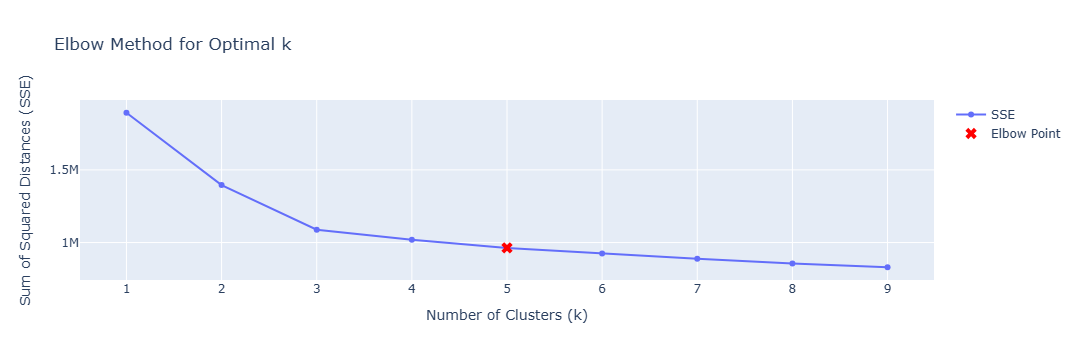

In [34]:
# Create a Plotly figure
fig = go.Figure()

# Add a scatter plot for the SSE values
fig.add_trace(go.Scatter(x=np.arange(1, 10), y=sse, mode='lines+markers', name='SSE'))

# Highlight the elbow point
elbow_k = 5  # Change this to the detected elbow point
fig.add_trace(go.Scatter(x=[elbow_k], y=[sse[elbow_k - 1]], mode='markers', marker=dict(size=10, color='red', symbol='x'), name='Elbow Point'))

# Update layout
fig.update_layout(title='Elbow Method for Optimal k',
                  xaxis_title='Number of Clusters (k)',
                  yaxis_title='Sum of Squared Distances (SSE)',
                  showlegend=True)

# Show the plot
fig.show()

<h1 style="color:salmon" id="81">K-means Clusetring Visualisation with the help of PCA 3 components</h1>

In [41]:
# PCA 3 Components 
pca, x_3pca = do_pca(3, train_5_labels.drop(columns="label"))
x_3pca.shape

(30000, 3)

In [43]:
x_3pca_df = pd.DataFrame(x_3pca, columns=["component1", "component2", "component3"])
x_3pca_df.head()

component1  component2  component3
0   11.414313   16.497276    5.625891
1    8.545677  -12.316917    1.197881
2    9.003173    9.646144   -6.977575
3   16.309910   -6.673696   -3.453813
4  -23.167697    4.759955   -6.006893

In [47]:
train_5_labels.shape

(30000, 785)

In [53]:
x_3pca_df["label"] = train_5_labels["label"].values
x_3pca_df

component1  component2  component3  label
0       11.414313   16.497276    5.625891      2
1        8.545677  -12.316917    1.197881      3
2        9.003173    9.646144   -6.977575      4
3       16.309910   -6.673696   -3.453813      4
4      -23.167697    4.759955   -6.006893      5
...           ...         ...         ...    ...
29995   14.417953   -5.001276   -2.819267      4
29996   -8.035726   17.585727   11.474828      5
29997  -24.200379   15.050351   13.468413      5
29998   20.460393   10.269069   -2.129959      2
29999  -12.971900   -8.679104    0.957135      1

[30000 rows x 4 columns]

In [54]:
x_3pca_df.columns

Index(['component1', 'component2', 'component3', 'label'], dtype='object')

In [112]:
def plot_3d_clusters(df, feature_cols, num_clusters, kmeans_on=True):
    # extract the feature columns from the dataframe
    X = df[feature_cols]

    if kmeans_on == True:
        # perform K-means clustering with the specified number of clusters
        kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(X)
        df['cluster'] = kmeans.labels_
    
    else:
        df['cluster'] = df["label"]

    # create 3D scatter plot of the clustered data
    fig = go.Figure()

    # Scatter points for each cluster
    for cluster in df['cluster'].unique():
        cluster_data = df[df['cluster'] == cluster]
        scatter = go.Scatter3d(
            x=cluster_data[feature_cols[0]],
            y=cluster_data[feature_cols[1]],
            z=cluster_data[feature_cols[2]],
            mode='markers',
            marker=dict(
                size=5,
                opacity=0.5,
            ),
            name= f'Cluster {cluster}' if kmeans_on==True else f'True Label {cluster}'
        )
        fig.add_trace(scatter)

    fig.update_layout(scene=dict(
        xaxis_title=feature_cols[0],
        yaxis_title=feature_cols[1],
        zaxis_title=feature_cols[2]
    ), title=f'K-means Clustering {num_clusters} Clusters) 3D Scatter Plot' if kmeans_on==True else f'Labels distribution 3D Scatter Plot')



    return fig


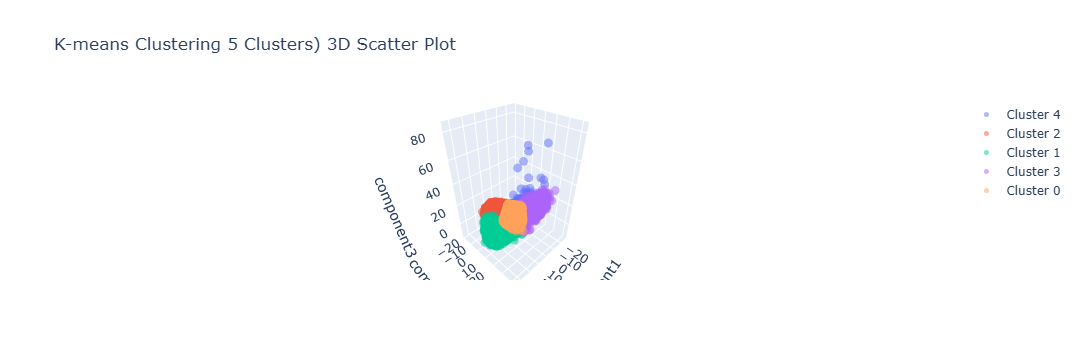

In [113]:
fig = plot_3d_clusters(x_3pca_df, ['component1', 'component2', 'component3'], 5)
fig.show()

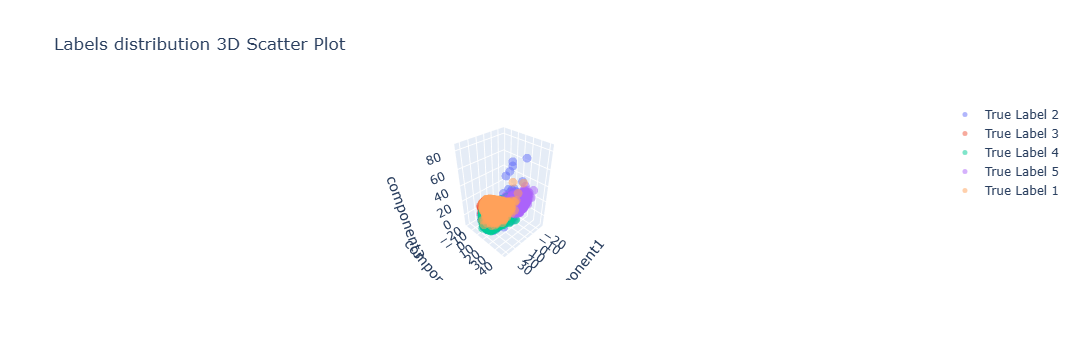

In [114]:
fig = plot_3d_clusters(x_3pca_df, ['component1', 'component2', 'component3'], 5, kmeans_on=False)
fig.show()

In [109]:
from mpl_toolkits.mplot3d import Axes3D

def plot_3d_clusters_seaborn(df, feature_cols, num_clusters, kmeans_on=True):
    # extract the feature columns from the dataframe
    X = df[feature_cols]

    if kmeans_on:
        # perform K-means clustering with the specified number of clusters
        kmeans = KMeans(n_clusters=num_clusters, random_state=42).fit(X)
        df['cluster'] = kmeans.labels_
    
    else:
        df['cluster'] = df["label"]

    # create 3D scatter plot of the clustered data
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')

    # Scatter points for each cluster
    for cluster in df['cluster'].unique():
        cluster_data = df[df['cluster'] == cluster]
        ax.scatter(
            cluster_data[feature_cols[0]],
            cluster_data[feature_cols[1]],
            cluster_data[feature_cols[2]],
            s=50,
            alpha=0.5,
            label=f'Cluster {cluster}' if kmeans_on else f'True Label {cluster}'
        )

    ax.set_xlabel(feature_cols[0])
    ax.set_ylabel(feature_cols[1])
    ax.set_zlabel(feature_cols[2])
    ax.set_title(f'K-means Clustering {num_clusters} Clusters 3D Scatter Plot' if kmeans_on else f'Labels distribution 3D Scatter Plot')
    ax.legend()

    return fig


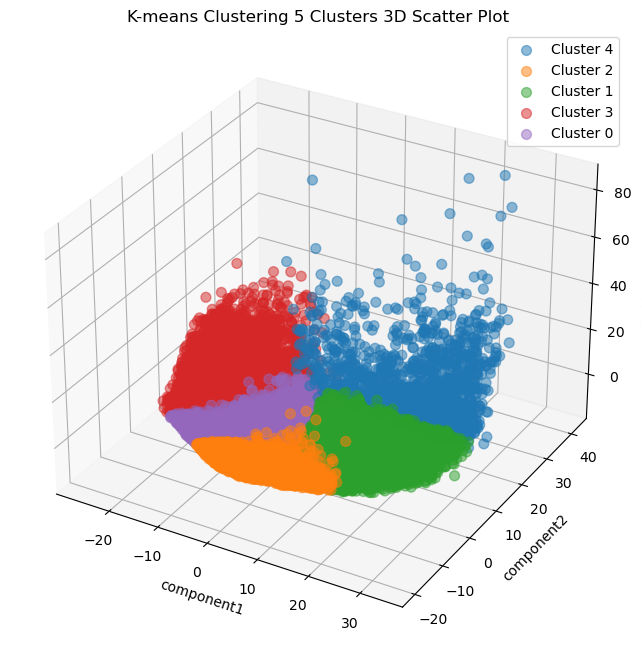

In [110]:
fig = plot_3d_clusters_seaborn(x_3pca_df, ['component1', 'component2', 'component3'], 5)
fig.show()

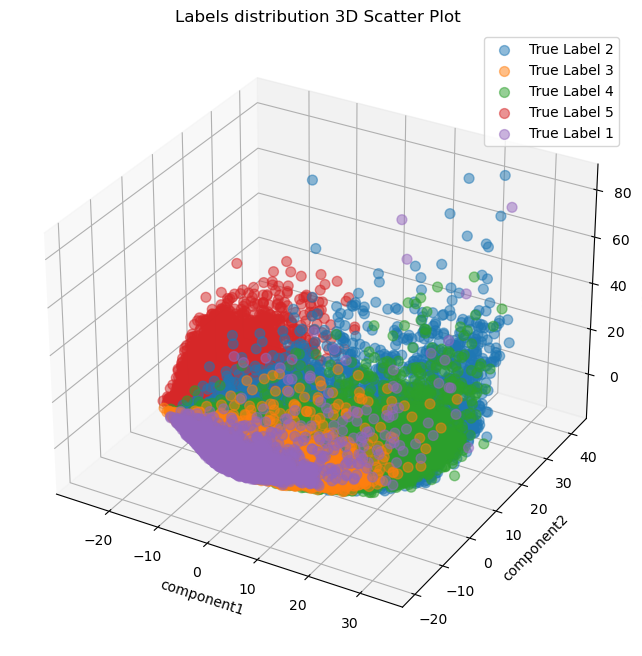

In [111]:
fig = plot_3d_clusters_seaborn(x_3pca_df, ['component1', 'component2', 'component3'], 5, kmeans_on=False)
fig.show()

<h1 id="9" style="color:salmon">Models Saving for deployment</h1>

In [127]:
pca40

PCA(n_components=40)

In [129]:
# Save the pca object 
joblib.dump(pca40, 'models/pca_object.pkl')

['models/pca_object.pkl']

In [130]:
# Logistic models 
# logRegFinal pixel value
joblib.dump(logRegFinal, 'models/LogisticRegressionPixel.pkl')
# logistic on PCA 40
joblib.dump(logRegPca40, 'models/LogisticRegressionPCA_40.pkl')
# logistic on HoG
joblib.dump(logRegHog, 'models/LogisticRegressionHoG.pkl')

['models/LogisticRegressionHoG.pkl']

In [79]:
joblib.dump(logRegMix1, 'models/LogisticRegressionMixPCAHOG.pkl')

['models/LogisticRegressionMixPCAHOG.pkl']

<h1 id="10" style="color:salmon">Models Evaluation</h1>

<h2 id="101" style="color:skyblue">Logistic Regression Pixel Value</h2>

In [10]:
# loading model 
final_model = joblib.load('models/LogisticRegressionPixel.pkl')
final_model

LogisticRegression(C=10, max_iter=3, solver='saga')

In [11]:
# confusion_matrix 
y_pred = final_model.predict(X_test_px)
conf = confusion_matrix(y_test_px, y_pred)
display(conf)

array([[817,   3,  13,  49,   0,   2,  95,   0,  20,   1],
       [  0, 969,   4,  16,   2,   1,   8,   0,   0,   0],
       [ 14,   1, 765,  12, 106,   0,  90,   0,  12,   0],
       [ 27,  18,  14, 893,  23,   0,  23,   0,   2,   0],
       [  1,   0,  84,  34, 792,   0,  86,   0,   3,   0],
       [  2,   0,   0,   1,   0, 918,   1,  47,   9,  22],
       [148,   6, 100,  31,  82,   1, 613,   0,  19,   0],
       [  0,   0,   0,   0,   0,  41,   0, 910,   1,  48],
       [  5,   0,   5,   5,   4,   7,  16,   5, 951,   2],
       [  0,   0,   0,   0,   0,  16,   0,  36,   2, 946]], dtype=int64)

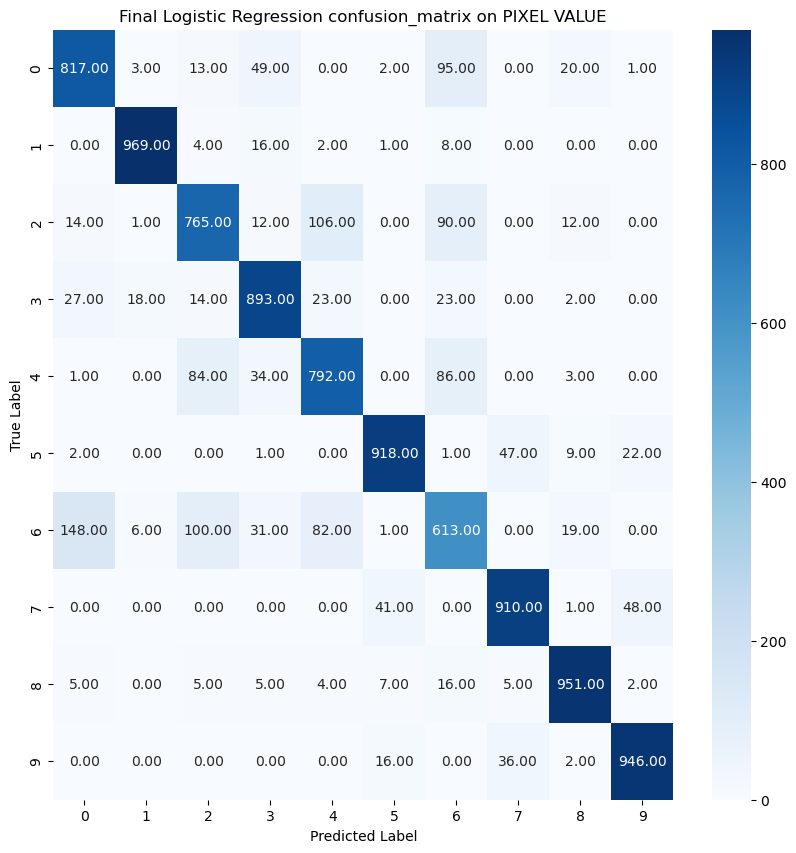

In [13]:
# visualise it 
plt.figure(figsize=(10,10))
sns.heatmap(conf, annot=True, cmap="Blues", fmt=".2f")

# Add labels to the axes
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# title
plt.title("Final Logistic Regression confusion_matrix on PIXEL VALUE")

# show
plt.show()

>Recall how much you predicted correctly from the total of actual number in this class 
نسبه التوقعات الصح من اجمالى كل الصح فى الداتا ست للكلاس ده

>Precision how much you predicted correctly from all the predictions for that class
نسبة التوقعات الصح من اجمالى كل التوقعات المعمولة للكلاس ده

<div style="border-radius:10px;border:skyblue solid;padding: 15px;background-color:#ffffff00;font-size:100%;text-align:left">

Precision: Precision is the ratio of correctly predicted positive observations to the total predicted positives. In a multi-class setting, it's calculated for each class. For example, the precision for class 0 is 0.81, meaning that 81% of the instances predicted as class 0 are actually class 0.

Recall (Sensitivity): Recall is the ratio of correctly predicted positive observations to the all observations in the actual class. Again, it's calculated for each class. For instance, the recall for class 1 is 0.97, indicating that 97% of the instances belonging to class 1 were correctly predicted.

F1-Score: The F1-Score is the weighted average of precision and recall. It ranges from 0 to 1, where 1 is the best score. It's a harmonic mean of precision and recall and is particularly useful when the classes are imbalanced. It's also computed for each class.

Support: Support is the number of actual occurrences of the class in the specified dataset. In your case, each class has 1000 instances.

Accuracy: Overall accuracy is the ratio of correctly predicted instances to the total instances. In this case, the overall accuracy is 0.86, meaning that the model correctly predicted the class for 86% of the instances.

Macro Average: Macro average takes the average of the precision, recall, and F1-score for each class without considering class imbalance.

Weighted Average: Weighted average considers the number of instances for each class, giving more weight to classes with more instances. It's particularly useful when the classes are imbalanced.
</div>

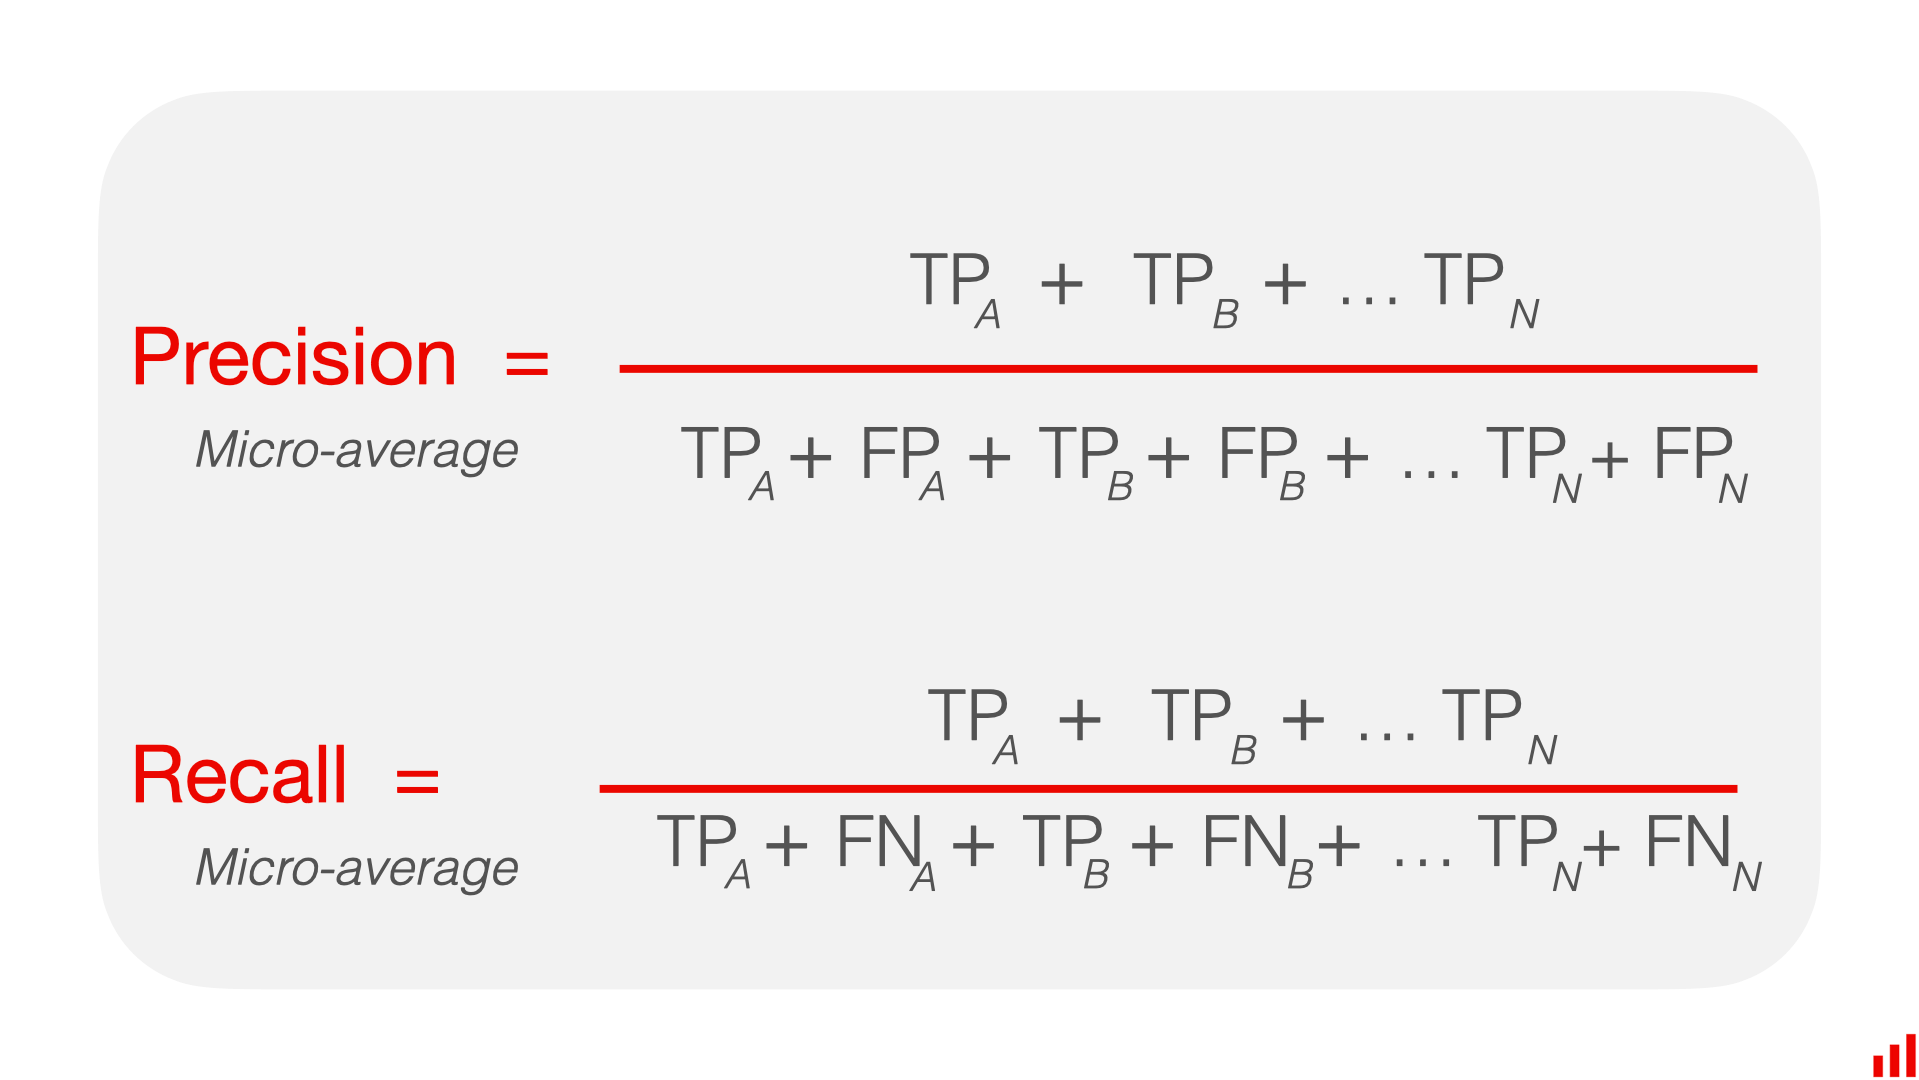

In [14]:
# classification report
report = classification_report(y_test_px, y_pred)
print(report)

              precision    recall  f1-score   support



           0       0.81      0.82      0.81      1000

           1       0.97      0.97      0.97      1000

           2       0.78      0.77      0.77      1000

           3       0.86      0.89      0.88      1000

           4       0.78      0.79      0.79      1000

           5       0.93      0.92      0.92      1000

           6       0.66      0.61      0.63      1000

           7       0.91      0.91      0.91      1000

           8       0.93      0.95      0.94      1000

           9       0.93      0.95      0.94      1000



    accuracy                           0.86     10000

   macro avg       0.86      0.86      0.86     10000

weighted avg       0.86      0.86      0.86     10000




In [49]:
def ROC_draw(model, feature_extraction, y_test, x_test):
    num_classes = 10

    # Convert multi-class labels into binary labels
    '''
    Converts the true multi-class labels (y_test_px) into binary format. This is often necessary for ROC curve computation.
    '''
    y_true_binary = label_binarize(y_test, classes=range(num_classes))

    # Predict probabilities
    y_scores = model.predict_proba(x_test)

    # Compute ROC curve and ROC area for each class
    plt.figure(figsize=(8, 6), dpi=150)
    fpr, tpr, roc_auc = {}, {}, {}
    for i in range(num_classes):
        fpr[i], tpr[i], _ = roc_curve(y_true_binary[:, i], y_scores[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])
        plt.plot(fpr[i], tpr[i], label=f'Class {i} (AUC = {roc_auc[i]:.2f})')
    # plotting each class
    plt.title(f"ROC CURVE LOGISTIC REGRESSION {feature_extraction} ")
    plt.legend(loc='lower right')
    plt.show()

    # Compute micro-average ROC curve and ROC area
    '''ravel()
    x = np.array([[1, 2, 3], [4, 5, 6]])
    np.ravel(x)
    array([1, 2, 3, 4, 5, 6]) 
    '''
    fpr["micro"], tpr["micro"], _ = roc_curve(y_true_binary.ravel(), y_scores.ravel())
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    # Plot micro-average ROC curve
    plt.figure(figsize=(8, 6), dpi=150)
    plt.plot(fpr["micro"], tpr["micro"], label=f'Micro-average ROC curve (AUC = {roc_auc["micro"]:.2f})', color='deeppink', linestyle=':', linewidth=4)

    # Plot macro-average ROC curve
    all_fpr = np.unique(np.concatenate(list(fpr.values())))
    mean_tpr = np.zeros_like(all_fpr)
    for i in range(num_classes):
        mean_tpr += np.interp(all_fpr, fpr[i], tpr[i])
    mean_tpr /= num_classes
    fpr["macro"], tpr["macro"] = all_fpr, mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])
    plt.plot(fpr["macro"], tpr["macro"], label=f'Macro-average ROC curve (AUC = {roc_auc["macro"]:.2f})', color='navy', linestyle=':', linewidth=4)

    # Customize the plot
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', linewidth=2, label='Random', alpha=0.8)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Multi-Class ROC Curve {feature_extraction}')
    plt.legend(loc='lower right')
    plt.show()


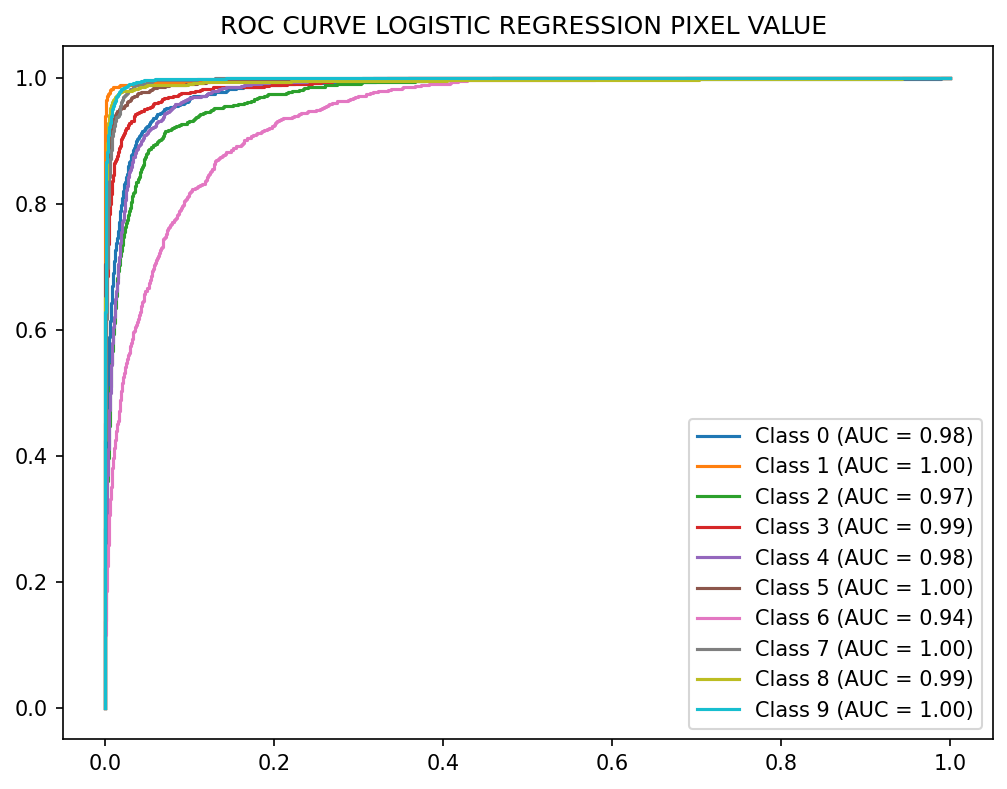

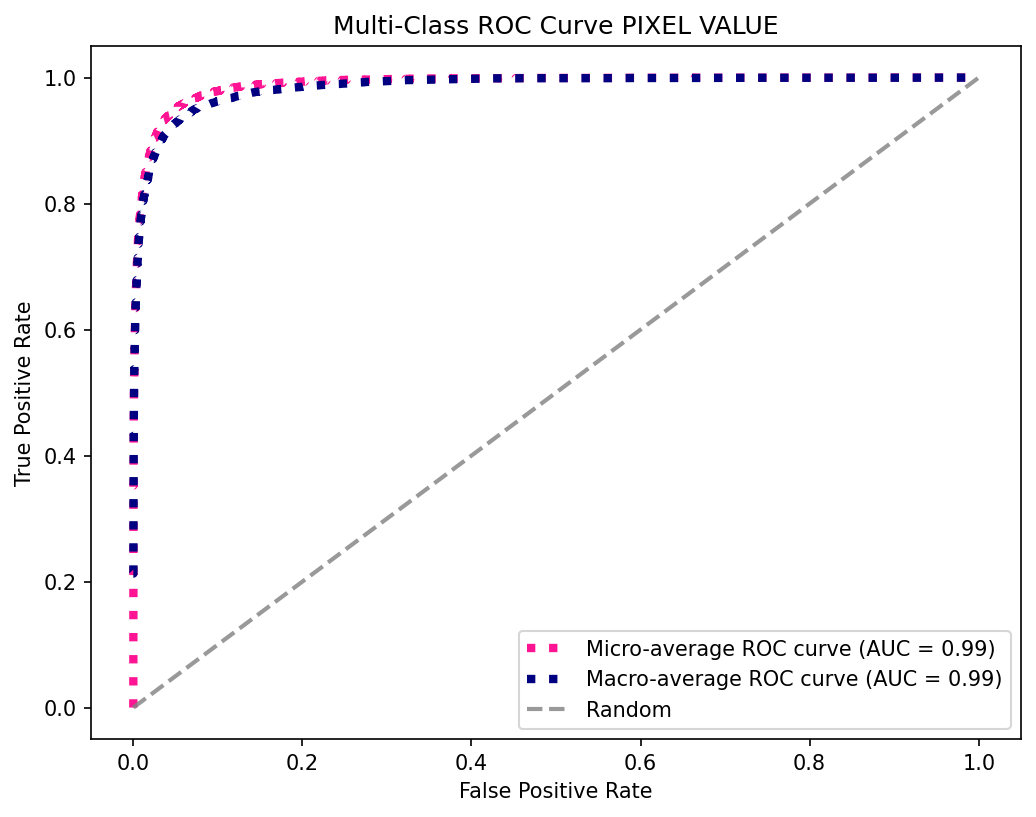

In [50]:
ROC_draw(final_model, "PIXEL VALUE", y_test_px, X_test_px)

In [43]:
# loading logistic regression HoG
logRegHog_load = joblib.load("models/LogisticRegressionHoG.pkl")
# loading logistic regression PCA
logRegPca40_load = joblib.load("models/LogisticRegressionPCA_40.pkl")

<h2 id="102" style="color:skyblue">Logistic Regression HoG Features</h2>

In [44]:
# Hog 
logRegHog_load

LogisticRegression(solver='saga')

In [45]:
# confusion_matrix 
y_pred = logRegHog_load.predict(X_test_hog)
conf = confusion_matrix(y_test_hog, y_pred)
display(conf)

array([[786,  10,  49,  46,  12,   2,  82,   0,  13,   0],
       [  1, 956,   9,  24,   1,   0,   8,   0,   1,   0],
       [ 18,   1, 699,   7, 141,   1, 127,   0,   6,   0],
       [ 22,  29,  19, 851,  44,   1,  32,   0,   2,   0],
       [  1,   1,  84,  40, 767,   1, 102,   0,   4,   0],
       [  0,   1,   0,   0,   0, 875,   0,  97,   2,  25],
       [158,   6, 169,  43, 144,   2, 465,   0,  13,   0],
       [  0,   0,   0,   0,   0,  62,   0, 885,   0,  53],
       [  4,   2,   9,  13,   8,   8,  17,   2, 935,   2],
       [  0,   0,   0,   1,   0,  15,   0,  57,   2, 925]], dtype=int64)

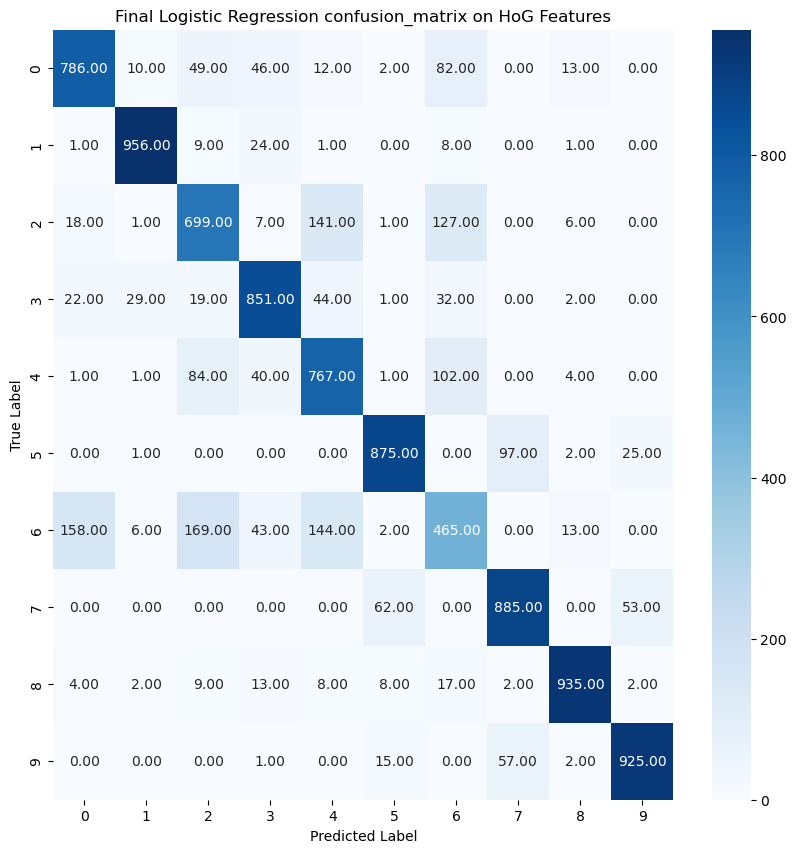

In [47]:
# visualise it 
plt.figure(figsize=(10,10))
sns.heatmap(conf, annot=True, cmap="Blues", fmt=".2f")

# Add labels to the axes
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# title
plt.title("Final Logistic Regression confusion_matrix on HoG Features")

# show
plt.show()

In [48]:
# classification report
report = classification_report(y_test_hog, y_pred)
print(report)

              precision    recall  f1-score   support



           0       0.79      0.79      0.79      1000

           1       0.95      0.96      0.95      1000

           2       0.67      0.70      0.69      1000

           3       0.83      0.85      0.84      1000

           4       0.69      0.77      0.72      1000

           5       0.90      0.88      0.89      1000

           6       0.56      0.47      0.51      1000

           7       0.85      0.89      0.87      1000

           8       0.96      0.94      0.95      1000

           9       0.92      0.93      0.92      1000



    accuracy                           0.81     10000

   macro avg       0.81      0.81      0.81     10000

weighted avg       0.81      0.81      0.81     10000




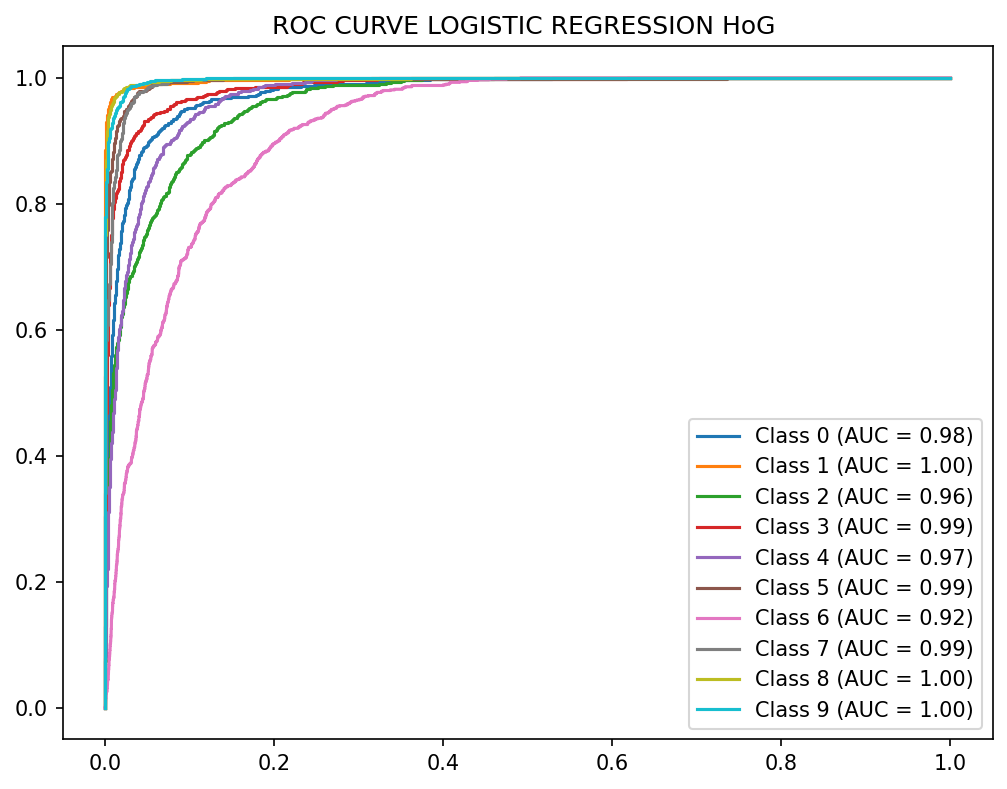

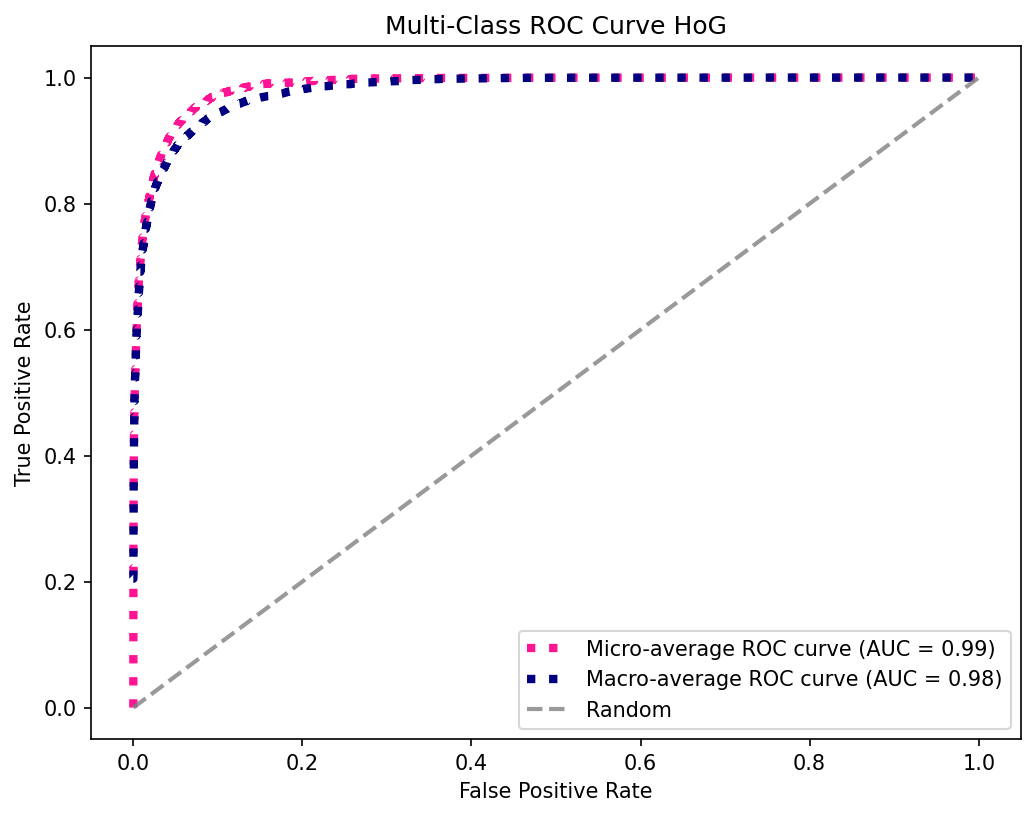

In [51]:
ROC_draw(logRegHog_load, "HoG", y_test_hog, X_test_hog)

<h2 id="103" style="color:skyblue">Logistic Regression PCA 40 Features</h2>

In [52]:
# logRegPca40_load
logRegPca40_load

LogisticRegression(solver='saga')

In [54]:
# confusion_matrix 
y_pred = logRegPca40_load.predict(X_test_40pc)
conf = confusion_matrix(y_test_40pca, y_pred)
display(conf)

array([[789,   8,  13,  74,   2,   5,  90,   0,  19,   0],
       [  1, 956,   4,  27,   1,   0,  11,   0,   0,   0],
       [ 16,   3, 693,  11, 139,   1, 128,   0,   9,   0],
       [ 38,  21,   8, 861,  29,   2,  39,   0,   2,   0],
       [  0,   6,  78,  33, 774,   2, 102,   1,   4,   0],
       [  3,   0,   0,   1,   0, 868,   1,  91,   6,  30],
       [165,   3, 134,  55, 110,   5, 507,   2,  18,   1],
       [  0,   0,   0,   0,   0,  70,   0, 827,   1, 102],
       [  1,   3,   5,   9,   7,   8,  25,   4, 933,   5],
       [  0,   0,   0,   0,   0,  29,   0,  52,   0, 919]], dtype=int64)

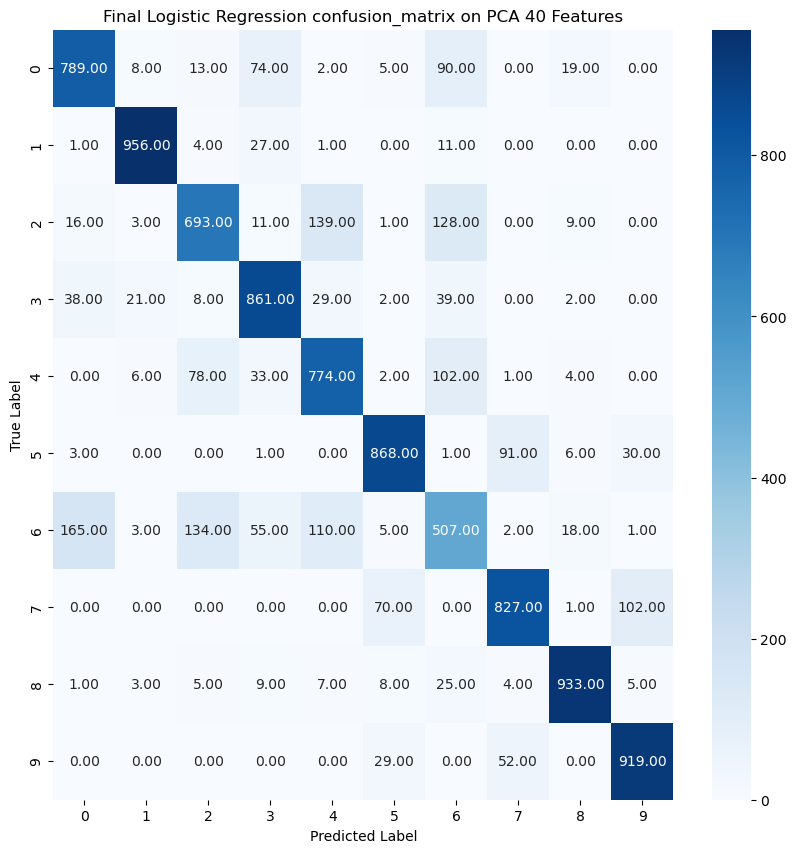

In [55]:
# visualise it 
plt.figure(figsize=(10,10))
sns.heatmap(conf, annot=True, cmap="Blues", fmt=".2f")

# Add labels to the axes
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# title
plt.title("Final Logistic Regression confusion_matrix on PCA 40 Features")

# show
plt.show()

In [56]:
# classification report
report = classification_report(y_test_40pca, y_pred)
print(report)

              precision    recall  f1-score   support



           0       0.78      0.79      0.78      1000

           1       0.96      0.96      0.96      1000

           2       0.74      0.69      0.72      1000

           3       0.80      0.86      0.83      1000

           4       0.73      0.77      0.75      1000

           5       0.88      0.87      0.87      1000

           6       0.56      0.51      0.53      1000

           7       0.85      0.83      0.84      1000

           8       0.94      0.93      0.94      1000

           9       0.87      0.92      0.89      1000



    accuracy                           0.81     10000

   macro avg       0.81      0.81      0.81     10000

weighted avg       0.81      0.81      0.81     10000




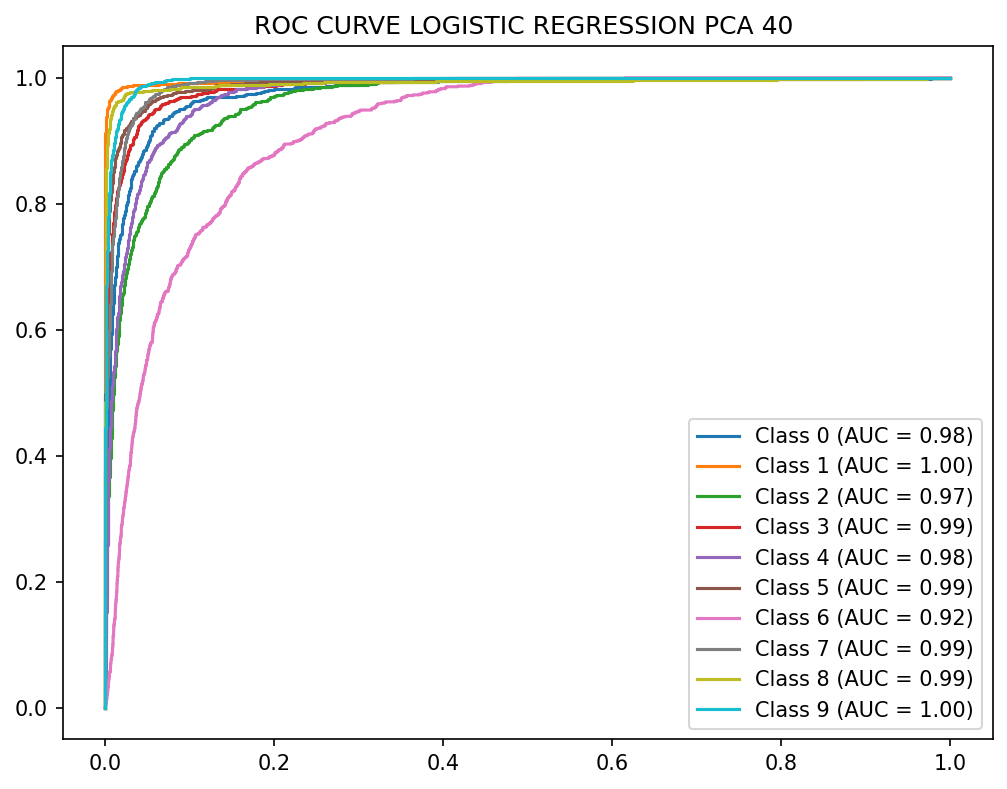

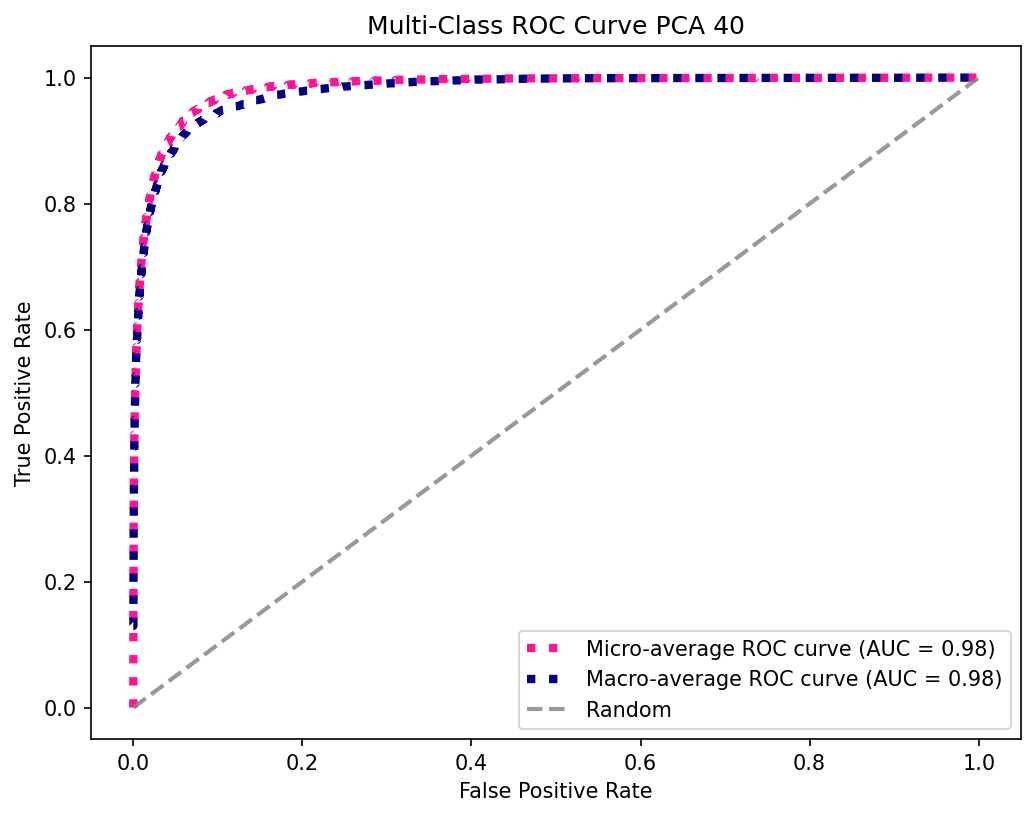

In [57]:
ROC_draw(logRegPca40_load, "PCA 40", y_test_40pca, X_test_40pc)

<h2 id="104" style="color:skyblue">Logistic Regression Mix of PCA & HOG</h2>

In [80]:
logRegMix1

LogisticRegression(max_iter=300, solver='saga')

In [81]:
# confusion_matrix 
y_pred = logRegMix1.predict(X_train_mix1)
conf = confusion_matrix(y_train_mix1, y_pred)
display(conf)

array([[4979,   17,   79,  399,   30,   11,  414,    6,   63,    2],
       [  16, 5724,   31,  174,   23,    1,   29,    0,    2,    0],
       [  80,   19, 4261,   59,  866,   10,  662,    3,   38,    2],
       [ 225,   90,   37, 5181,  215,    3,  228,    6,   13,    2],
       [  11,   26,  496,  232, 4587,    8,  602,    4,   34,    0],
       [   3,    0,    0,    3,    1, 5460,    2,  373,   24,  134],
       [ 975,   20,  753,  265,  765,    7, 3120,    5,   90,    0],
       [   0,    0,    0,    0,    0,  350,    0, 5327,   15,  308],
       [  22,    8,   20,   65,   23,   45,  126,   20, 5659,   12],
       [   0,    3,    0,    0,    0,  108,    1,  295,    2, 5591]],
      dtype=int64)

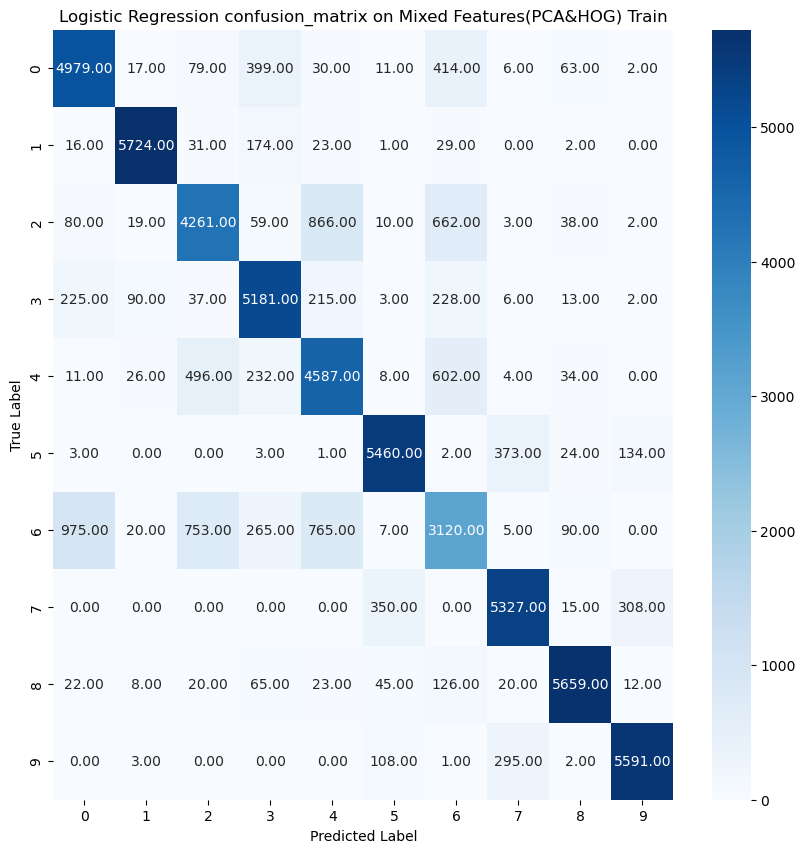

In [83]:
# visualise it 
plt.figure(figsize=(10,10))
sns.heatmap(conf, annot=True, cmap="Blues", fmt=".2f")

# Add labels to the axes
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

# title
plt.title("Logistic Regression confusion_matrix on Mixed Features(PCA&HOG) Train")

# show
plt.show()

In [84]:
# classification report
report = classification_report(y_train_mix1, y_pred)
print(report)

              precision    recall  f1-score   support



           0       0.79      0.83      0.81      6000

           1       0.97      0.95      0.96      6000

           2       0.75      0.71      0.73      6000

           3       0.81      0.86      0.84      6000

           4       0.70      0.76      0.73      6000

           5       0.91      0.91      0.91      6000

           6       0.60      0.52      0.56      6000

           7       0.88      0.89      0.88      6000

           8       0.95      0.94      0.95      6000

           9       0.92      0.93      0.93      6000



    accuracy                           0.83     60000

   macro avg       0.83      0.83      0.83     60000

weighted avg       0.83      0.83      0.83     60000




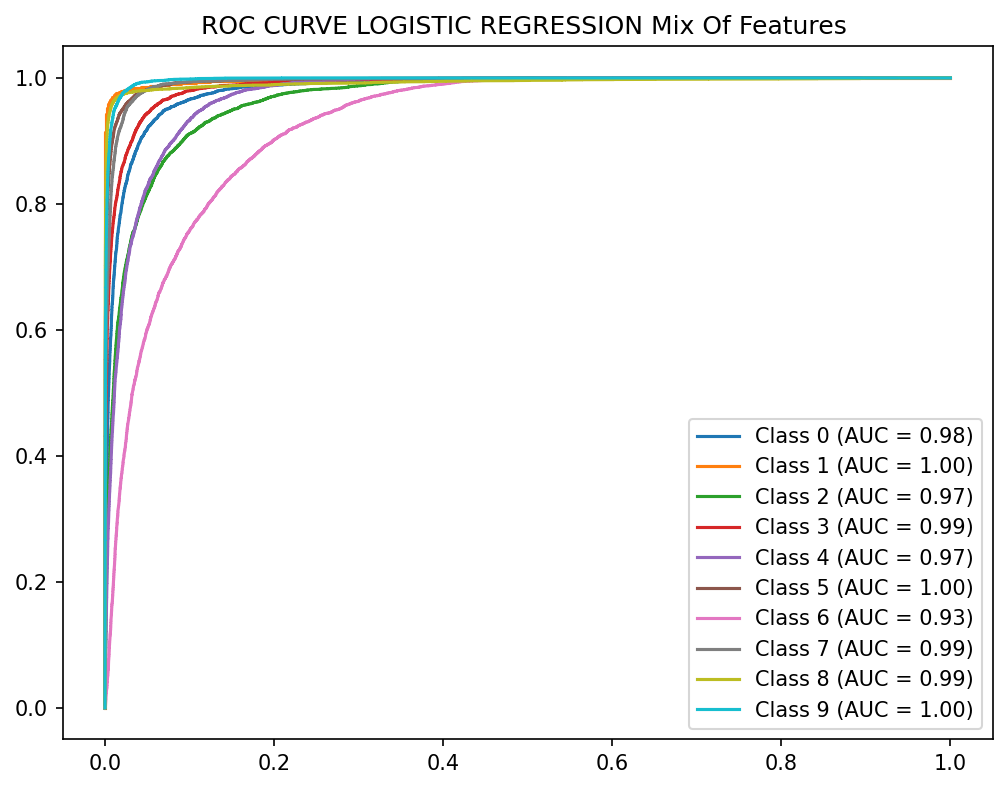

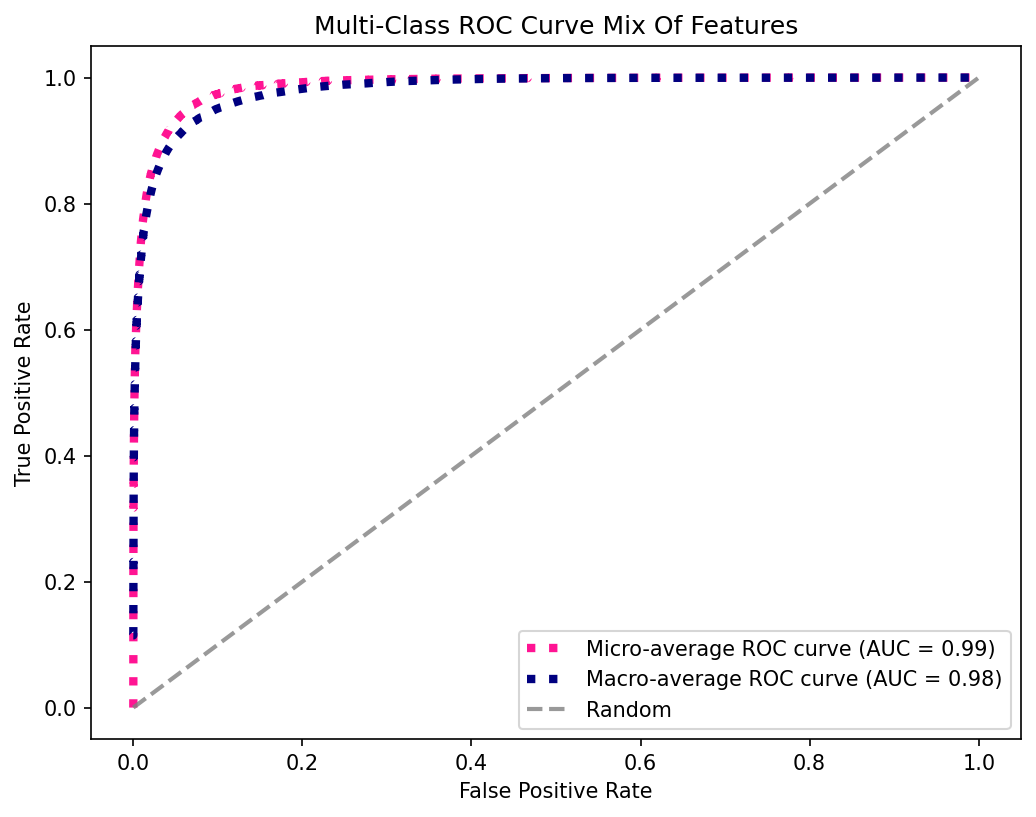

In [85]:
ROC_draw(logRegMix1, "Mix Of Features", y_train_mix1, X_train_mix1)